Basic data cleaning


In [2]:
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime

# Configuration
INPUT_FILE = 'umact.csv'  # Change this to your input file path
OUTPUT_FILE = 'cleaned_UMBank_complaints_data.csv'

def load_data(file_path):
    """
    Load the dataset from CSV file.

    Args:
        file_path (str): Path to the input CSV file

    Returns:
        pd.DataFrame: Loaded dataframe or None if error
    """
    try:
        print(f"Loading data from {file_path}...")
        df = pd.read_csv(file_path)
        print(f"Successfully loaded: {df.shape}")
        print(f"Total complaints to process: {len(df):,}")
        return df
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return None
    except Exception as e:
        print(f"Data loading error: {e}")
        return None

def display_data_info(df, stage="Initial"):
    """
    Display basic information about the dataframe.

    Args:
        df (pd.DataFrame): Dataframe to analyze
        stage (str): Stage of cleaning (for display purposes)
    """
    if df is None:
        print("DataFrame is None. Cannot display info.")
        return

    print(f"\n--- {stage} Data Information ---")
    print(f"Shape: {df.shape}")
    print("\n--- Data types and non-null counts ---")
    df.info()

    print(f"\n--- Missing values per column ---")
    missing_counts = df.isnull().sum()
    print(missing_counts[missing_counts > 0])

    print(f"\n--- First 5 rows ---")
    print(df.head())

def clean_date_columns(df):
    """
    Clean and convert date columns to datetime objects.

    Args:
        df (pd.DataFrame): Input dataframe

    Returns:
        pd.DataFrame: Dataframe with cleaned date columns
    """
    print("\n--- Handling Date Columns ---")
    date_columns = ['Date_received', 'Date_sent']
    existing_date_cols = []

    df_copy = df.copy()

    for col in date_columns:
        if col in df_copy.columns:
            print(f"\nProcessing column: {col}")
            original_nulls = df_copy[col].isnull().sum()
            df_copy[col] = pd.to_datetime(df_copy[col], dayfirst=True, errors='coerce')

            new_nulls = df_copy[col].isnull().sum()
            if new_nulls > original_nulls:
                print(f"Warning: Some values in '{col}' could not be parsed as dates. Additional NaNs: {new_nulls - original_nulls}")

            if df_copy[col].notna().any():
                print(f"Sample of parsed dates in '{col}':")
                print(df_copy[col].dropna().head())
                print(f"Date range: {df_copy[col].min()} to {df_copy[col].max()}")

            print(f"Column '{col}' converted to datetime objects.")
            existing_date_cols.append(col)
        else:
            print(f"Warning: Date column '{col}' not found. Skipping.")

    if existing_date_cols:
        print(f"\n--- Processed {len(existing_date_cols)} date columns successfully ---")
    else:
        print("\nNo date columns were found or processed.")

    return df_copy

def clean_categorical_columns(df):
    """
    Handle missing values in categorical columns.

    Args:
        df (pd.DataFrame): Input dataframe

    Returns:
        pd.DataFrame: Dataframe with cleaned categorical columns
    """
    print("\n--- Handling Missing Values in Categorical Columns ---")
    df_copy = df.copy()

    categorical_fill_unknown = ['Sub-product', 'Sub-issue', 'State']

    for col in categorical_fill_unknown:
        if col in df_copy.columns:
            missing_before = df_copy[col].isnull().sum()
            if missing_before > 0:
                df_copy[col] = df_copy[col].fillna('Unknown')
                print(f"Filled {missing_before} NaNs in '{col}' with 'Unknown'.")
            else:
                print(f"No NaNs to fill in '{col}'.")
        else:
            print(f"Warning: Categorical column '{col}' not found. Skipping.")

    return df_copy

def clean_zip_column(df):
    """
    Clean ZIP code column.

    Args:
        df (pd.DataFrame): Input dataframe

    Returns:
        tuple: (cleaned dataframe, zip column name or None)
    """
    print("\n--- Handling Missing Values and Type for ZIP Code Column ---")
    df_copy = df.copy()

    zip_col_name = 'ZIP'
    if zip_col_name in df_copy.columns:
        missing_before = df_copy[zip_col_name].isnull().sum()
        df_copy[zip_col_name] = df_copy[zip_col_name].astype(str).fillna('00000')
        print(f"Ensured '{zip_col_name}' is string type. Filled {missing_before} NaNs with '00000'.")
        return df_copy, zip_col_name
    else:
        zip_col_name_alt = 'ZIP code'
        if zip_col_name_alt in df_copy.columns:
            zip_col_name = zip_col_name_alt
            missing_before = df_copy[zip_col_name].isnull().sum()
            df_copy[zip_col_name] = df_copy[zip_col_name].astype(str).fillna('00000')
            print(f"Found column as '{zip_col_name}'. Filled {missing_before} NaNs with '00000'.")
            return df_copy, zip_col_name
        else:
            print("Warning: ZIP code column not found. Skipping ZIP code cleaning.")
            return df_copy, None

def clean_disputed_column(df):
    """
    Clean and standardize the 'Consumer disputed?' column.

    Args:
        df (pd.DataFrame): Input dataframe

    Returns:
        pd.DataFrame: Dataframe with cleaned disputed column
    """
    print("\n--- Cleaning 'Disputed' Column ---")
    df_copy = df.copy()

    disputed_col_name = 'Consumer disputed?'
    if disputed_col_name in df_copy.columns:
        print(f"Unique values in '{disputed_col_name}' before cleaning: {df_copy[disputed_col_name].unique()}")
        missing_before = df_copy[disputed_col_name].isnull().sum()

        # Fill NaN values
        df_copy[disputed_col_name] = df_copy[disputed_col_name].fillna('Data Missing')

        # Standardize text
        df_copy[disputed_col_name] = df_copy[disputed_col_name].astype(str).str.lower().replace('n/a', 'not applicable')

        # Define valid values
        valid_disputed_values = ['yes', 'no', 'not applicable', 'data missing']

        # Replace 'nan' string with 'data missing'
        df_copy[disputed_col_name] = df_copy[disputed_col_name].replace('nan', 'data missing')

        # Ensure all values are valid
        df_copy[disputed_col_name] = df_copy[disputed_col_name].apply(
            lambda x: x if x in valid_disputed_values else 'data missing'
        )

        print(f"Filled/standardized NaNs in '{disputed_col_name}' (originally {missing_before} NaNs).")
        print(f"Unique values in '{disputed_col_name}' after cleaning: {df_copy[disputed_col_name].unique()}")
    else:
        print(f"Warning: Column '{disputed_col_name}' not found. Skipping 'Disputed' cleaning.")

    return df_copy

def remove_duplicates(df):
    """
    Check for and remove duplicate rows.

    Args:
        df (pd.DataFrame): Input dataframe

    Returns:
        pd.DataFrame: Dataframe without duplicates
    """
    print("\n--- Checking for and Removing Duplicate Rows ---")
    initial_row_count = len(df)
    df_copy = df.drop_duplicates()
    rows_dropped = initial_row_count - len(df_copy)

    if rows_dropped > 0:
        print(f"Removed {rows_dropped} duplicate rows.")
    else:
        print("No duplicate rows found.")

    print(f"Current number of rows: {len(df_copy)}")
    return df_copy

def display_unique_values(df, zip_col_name=None):
    """
    Display unique values in key categorical columns.

    Args:
        df (pd.DataFrame): Input dataframe
        zip_col_name (str): Name of ZIP column if found
    """
    print("\n--- Unique values in key categorical columns after cleaning ---")

    key_categorical_cols = [
        'Product', 'Sub-product', 'Issue', 'Sub-issue', 'State',
        'Response', 'Timely response?', 'Consumer disputed?'
    ]

    if zip_col_name and zip_col_name in df.columns:
        key_categorical_cols.append(zip_col_name)

    for col in key_categorical_cols:
        if col in df.columns:
            num_unique = df[col].nunique()
            unique_values = df[col].unique()
            if num_unique > 20:
                print(f"Unique values in '{col}' ({num_unique} total): {unique_values[:20]} ... (showing first 20)")
            else:
                print(f"Unique values in '{col}' ({num_unique} total): {unique_values}")
        else:
            print(f"Column '{col}' not found in DataFrame, skipping unique value display.")

def save_cleaned_data(df, output_file):
    """
    Save the cleaned dataframe to CSV file.

    Args:
        df (pd.DataFrame): Cleaned dataframe
        output_file (str): Output file path
    """
    try:
        df.to_csv(output_file, index=False)
        print(f"\nCleaned data saved to '{output_file}'")
        print(f"Final dataset shape: {df.shape}")
    except Exception as e:
        print(f"\nError saving the cleaned data: {e}")

def main():
    """
    Main function to orchestrate the data cleaning process.
    """
    print("="*70)
    print("UMBANK COMPLAINTS DATA CLEANING SCRIPT")
    print("="*70)
    print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    # Check if input file exists
    if not os.path.exists(INPUT_FILE):
        print(f"Error: Input file '{INPUT_FILE}' not found!")
        print("Please ensure the file exists in the current directory or update the INPUT_FILE variable.")
        sys.exit(1)

    # Step 1: Load data
    df = load_data(INPUT_FILE)
    if df is None:
        print("Failed to load data. Exiting.")
        sys.exit(1)

    # Step 2: Display initial data info
    display_data_info(df, "Initial")

    # Step 3: Clean date columns
    df = clean_date_columns(df)

    # Step 4: Clean categorical columns
    df = clean_categorical_columns(df)

    # Step 5: Clean ZIP column
    df, zip_col_name = clean_zip_column(df)

    # Step 6: Clean disputed column
    df = clean_disputed_column(df)

    # Step 7: Remove duplicates
    df = remove_duplicates(df)

    # Step 8: Display final data info
    display_data_info(df, "Final")

    # Step 9: Display unique values
    display_unique_values(df, zip_col_name)

    # Step 10: Save cleaned data
    save_cleaned_data(df, OUTPUT_FILE)

    print("\n" + "="*70)
    print("DATA CLEANING COMPLETED SUCCESSFULLY!")
    print("="*70)
    print(f"Finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("\nNext steps:")
    print("1. Review the cleaned dataset")
    print("2. Proceed with exploratory data analysis")
    print("3. Build your complaint classification models")

if __name__ == "__main__":
    main()

UMBANK COMPLAINTS DATA CLEANING SCRIPT
Started at: 2025-06-04 17:09:36
Loading data from umact.csv...
Successfully loaded: (27972, 13)
Total complaints to process: 27,972

--- Initial Data Information ---
Shape: (27972, 13)

--- Data types and non-null counts ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27972 entries, 0 to 27971
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Date_received       27972 non-null  object
 1   Product             27972 non-null  object
 2   Sub-product         25863 non-null  object
 3   Issue               27972 non-null  object
 4   Sub-issue           18655 non-null  object
 5   Complaint           27972 non-null  object
 6   State               27804 non-null  object
 7   ZIP                 27799 non-null  object
 8   Date_sent           27972 non-null  object
 9   Response            27972 non-null  object
 10  Timely response?    27972 non-null  object
 11

K Means Clustering and evaluate using silhoutte score


Loading model and generating embeddings...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embeddings shape: (17, 384)

K-MEANS CLUSTERING ANALYSIS
K-means k=2: Silhouette Score = 0.089
K-means k=3: Silhouette Score = 0.111
K-means k=4: Silhouette Score = 0.136
K-means k=5: Silhouette Score = 0.150
K-means k=6: Silhouette Score = 0.154
K-means k=7: Silhouette Score = 0.153
K-means k=8: Silhouette Score = 0.163
K-means k=9: Silhouette Score = 0.153
K-means k=10: Silhouette Score = 0.155

K-means Optimal k: 8, Best Score: 0.163

HIERARCHICAL CLUSTERING ANALYSIS

Testing ward linkage...
  k=2: Silhouette Score = 0.088
  k=3: Silhouette Score = 0.124
  k=4: Silhouette Score = 0.159
  k=5: Silhouette Score = 0.158
  k=6: Silhouette Score = 0.157
  k=7: Silhouette Score = 0.156
  k=8: Silhouette Score = 0.163
  k=9: Silhouette Score = 0.162
  k=10: Silhouette Score = 0.156
  Best k=8, Score=0.163

Testing complete linkage...
  k=2: Silhouette Score = 0.095
  k=3: Silhouette Score = 0.116
  k=4: Silhouette Score = 0.129
  k=5: Silhouette Score = 0.115
  k=6: Silhouette Score = 0.15

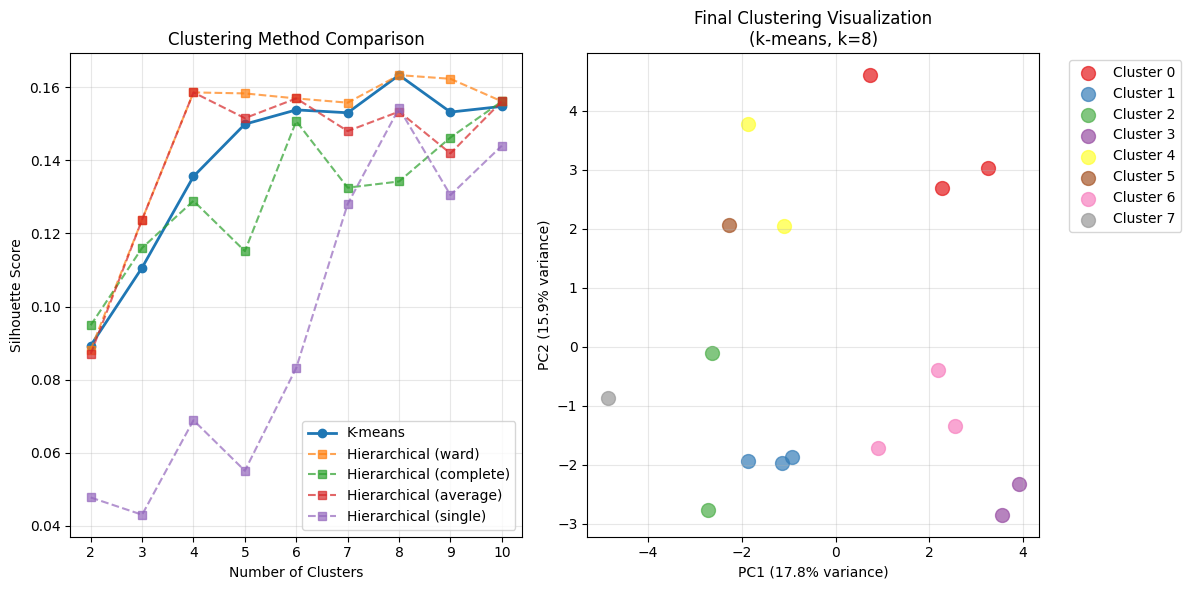

Analysis complete!


In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

# Financial services data
financial_services_data = {
    'Product': [
        'Credit card', 'Credit card or prepaid card', 'Prepaid card',
        'Consumer Loan', 'Mortgage', 'Payday loan',
        'Payday loan, title loan, or personal loan', 'Student loan',
        'Vehicle loan or lease', 'Bank account or service',
        'Checking or savings account', 'Credit reporting',
        'Credit reporting, credit repair services, or other personal consumer reports',
        'Debt collection', 'Money transfer, virtual currency, or money service',
        'Money transfers', 'Other financial service'
    ]
}

# Generate embeddings
print("Loading model and generating embeddings...")
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(financial_services_data['Product'])
print(f"Embeddings shape: {embeddings.shape}")

# Test range for clustering
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# =============================================================================
# K-MEANS CLUSTERING ANALYSIS
# =============================================================================
print("\n" + "="*50)
print("K-MEANS CLUSTERING ANALYSIS")
print("="*50)

kmeans_silhouette_scores = []
kmeans_results = {}

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)

    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    kmeans_silhouette_scores.append(silhouette_avg)
    kmeans_results[n_clusters] = {
        'labels': cluster_labels,
        'silhouette': silhouette_avg,
        'model': kmeans
    }

    print(f"K-means k={n_clusters}: Silhouette Score = {silhouette_avg:.3f}")

kmeans_optimal_k = range_n_clusters[np.argmax(kmeans_silhouette_scores)]
kmeans_best_score = max(kmeans_silhouette_scores)
print(f"\nK-means Optimal k: {kmeans_optimal_k}, Best Score: {kmeans_best_score:.3f}")

# =============================================================================
# HIERARCHICAL CLUSTERING ANALYSIS
# =============================================================================
print("\n" + "="*50)
print("HIERARCHICAL CLUSTERING ANALYSIS")
print("="*50)

# Test different linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']
hierarchical_results = {}

for method in linkage_methods:
    print(f"\nTesting {method} linkage...")
    silhouette_scores = []
    method_results = {}

    for n_clusters in range_n_clusters:
        agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
        cluster_labels = agglo.fit_predict(embeddings)

        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        method_results[n_clusters] = {
            'labels': cluster_labels,
            'silhouette': silhouette_avg
        }

        print(f"  k={n_clusters}: Silhouette Score = {silhouette_avg:.3f}")

    best_k = range_n_clusters[np.argmax(silhouette_scores)]
    best_score = max(silhouette_scores)

    hierarchical_results[method] = {
        'scores': silhouette_scores,
        'best_k': best_k,
        'best_score': best_score,
        'results': method_results
    }

    print(f"  Best k={best_k}, Score={best_score:.3f}")

# Find overall best hierarchical method
best_hierarchical_method = max(hierarchical_results.keys(),
                              key=lambda x: hierarchical_results[x]['best_score'])
hierarchical_optimal_k = hierarchical_results[best_hierarchical_method]['best_k']
hierarchical_best_score = hierarchical_results[best_hierarchical_method]['best_score']

print(f"\nBest Hierarchical: {best_hierarchical_method} linkage")
print(f"Optimal k: {hierarchical_optimal_k}, Best Score: {hierarchical_best_score:.3f}")

# =============================================================================
# COMPARISON AND FINAL ANALYSIS
# =============================================================================
print("\n" + "="*50)
print("METHOD COMPARISON")
print("="*50)

print(f"K-means:      k={kmeans_optimal_k}, Score={kmeans_best_score:.3f}")
print(f"Hierarchical: k={hierarchical_optimal_k}, Score={hierarchical_best_score:.3f} ({best_hierarchical_method})")

# Choose the better method
if hierarchical_best_score > kmeans_best_score:
    print(f"\n✓ Hierarchical clustering performs better (+{hierarchical_best_score - kmeans_best_score:.3f})")
    final_method = "hierarchical"
    final_k = hierarchical_optimal_k
    final_labels = hierarchical_results[best_hierarchical_method]['results'][hierarchical_optimal_k]['labels']
    final_score = hierarchical_best_score
else:
    print(f"\n✓ K-means clustering performs better (+{kmeans_best_score - hierarchical_best_score:.3f})")
    final_method = "k-means"
    final_k = kmeans_optimal_k
    final_labels = kmeans_results[kmeans_optimal_k]['labels']
    final_score = kmeans_best_score

# =============================================================================
# DETAILED CLUSTER ANALYSIS
# =============================================================================
print(f"\n" + "="*50)
print(f"FINAL CLUSTERING RESULTS ({final_method.upper()})")
print("="*50)

# Create results dataframe
results_df = pd.DataFrame({
    'Product': financial_services_data['Product'],
    'Cluster': final_labels
})

# Calculate individual silhouette scores
sample_silhouette_values = silhouette_samples(embeddings, final_labels)
results_df['Silhouette_Score'] = sample_silhouette_values

print(f"Method: {final_method}")
if final_method == "hierarchical":
    print(f"Linkage: {best_hierarchical_method}")
print(f"Number of clusters: {final_k}")
print(f"Overall silhouette score: {final_score:.3f}")

print(f"\nCluster breakdown:")
for cluster_id in range(final_k):
    cluster_products = results_df[results_df['Cluster'] == cluster_id]
    avg_silhouette = cluster_products['Silhouette_Score'].mean()

    print(f"\nCluster {cluster_id} (Size: {len(cluster_products)}, Avg Silhouette: {avg_silhouette:.3f}):")
    for _, row in cluster_products.iterrows():
        print(f"  - {row['Product']} (Score: {row['Silhouette_Score']:.3f})")

# =============================================================================
# VISUALIZATION
# =============================================================================
print(f"\n" + "="*50)
print("CREATING VISUALIZATIONS")
print("="*50)

# 1. Silhouette score comparison plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, kmeans_silhouette_scores, 'o-', label='K-means', linewidth=2)
for method in linkage_methods:
    plt.plot(range_n_clusters, hierarchical_results[method]['scores'],
             's--', label=f'Hierarchical ({method})', alpha=0.7)

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Clustering Method Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. PCA visualization of final clustering
plt.subplot(1, 2, 2)
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

colors = plt.cm.Set1(np.linspace(0, 1, final_k))
for i in range(final_k):
    cluster_points = embeddings_2d[final_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
               c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=100)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title(f'Final Clustering Visualization\n({final_method}, k={final_k})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Dendrogram for hierarchical clustering (if it's the winner)
if final_method == "hierarchical":
    plt.figure(figsize=(15, 8))
    Z = linkage(embeddings, method=best_hierarchical_method)
    dendrogram(
        Z,
        labels=financial_services_data['Product'],
        leaf_rotation=45,
        leaf_font_size=10
    )
    plt.title(f'Hierarchical Clustering Dendrogram ({best_hierarchical_method.capitalize()} Linkage)')
    plt.xlabel('Financial Products')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

print("Analysis complete!")


Volume, Complexity analysis to determine what types of grouping to group 17 types of products


In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns

class FixedUMBankClassifier:

    def __init__(self, csv_file_path='/content/cleaned_UMBank_complaints_data.csv'):
        self.csv_file_path = csv_file_path
        self.df = None
        self.volume_tiers = {}
        self.groups = {}

    def load_and_prepare_data(self):
        """Load and prepare the full dataset"""
        print("FIXED UMBANK CLASSIFIER - FULL DATASET")
        print("=" * 60)
        print(f"Loading data from: {self.csv_file_path}")

        try:
            self.df = pd.read_csv(self.csv_file_path, encoding='utf-8')
            print(f"Successfully loaded: {self.df.shape}")
            print(f"Total complaints: {len(self.df):,}")

            required_columns = ['Product', 'Sub-product', 'Issue', 'Sub-issue']
            missing_cols = [col for col in required_columns if col not in self.df.columns]

            if missing_cols:
                print(f"Missing columns: {missing_cols}")
                return None

            print(f"All required columns present: {required_columns}")

            print(f"\nACTUAL PRODUCT DISTRIBUTION:")
            product_counts = self.df['Product'].value_counts()
            for product, count in product_counts.items():
                print(f"  {product}: {count:,} complaints")

            print(f"\nTotal analyzed: {product_counts.sum():,} complaints")

            return self.df

        except Exception as e:
            print(f"Error loading data: {e}")
            return None

    def analyze_full_dataset_patterns(self):
        """Analyze patterns in the full dataset"""
        print(f"\n" + "=" * 60)
        print("FULL DATASET PATTERN ANALYSIS")
        print("=" * 60)

        product_volumes = self.df['Product'].value_counts()
        total_complaints = product_volumes.sum()

        print(f"Dataset Summary:")
        print(f"  Total complaints: {total_complaints:,}")
        print(f"  Unique products: {len(product_volumes)}")
        print(f"  Date range: {self.df['Date_received'].min()} to {self.df['Date_received'].max()}")

        volumes = product_volumes.values
        high_threshold = np.percentile(volumes, 75)  # Top 25%
        medium_threshold = np.percentile(volumes, 40)  # Middle

        print(f"\nVolume Tier Analysis:")
        print(f"  High volume threshold: >{high_threshold:.0f} complaints")
        print(f"  Medium volume threshold: {medium_threshold:.0f}-{high_threshold:.0f} complaints")
        print(f"  Low volume threshold: <{medium_threshold:.0f} complaints")

        self.volume_tiers = {
            'high': product_volumes[product_volumes > high_threshold].index.tolist(),
            'medium': product_volumes[(product_volumes >= medium_threshold) &
                                    (product_volumes <= high_threshold)].index.tolist(),
            'low': product_volumes[product_volumes < medium_threshold].index.tolist()
        }

        for tier, products in self.volume_tiers.items():
            tier_complaints = sum(product_volumes[p] for p in products)
            print(f"\n  {tier.title()} volume products ({len(products)} products, {tier_complaints:,} complaints):")
            for product in products:
                print(f"    • {product}: {product_volumes[product]:,}")

        return product_volumes

    def analyze_issue_complexity(self):
        """Analyze issue complexity across products"""
        print(f"\n" + "=" * 60)
        print("ISSUE COMPLEXITY ANALYSIS")
        print("=" * 60)

        product_issue_analysis = {}

        for product in self.df['Product'].unique():
            product_data = self.df[self.df['Product'] == product]

            issue_dist = product_data['Issue'].value_counts(normalize=True)

            issue_entropy = -sum(p * np.log2(p) for p in issue_dist if p > 0)
            max_entropy = np.log2(len(issue_dist)) if len(issue_dist) > 0 else 1
            complexity_score = issue_entropy / max_entropy if max_entropy > 0 else 0

            product_issue_analysis[product] = {
                'total_complaints': len(product_data),
                'unique_issues': len(issue_dist),
                'top_issue': issue_dist.index[0],
                'top_issue_pct': issue_dist.iloc[0],
                'complexity_score': complexity_score,
                'issue_diversity': len(issue_dist) / len(product_data)
            }

            print(f"\n{product} ({len(product_data):,} complaints):")
            print(f"  Unique issues: {len(issue_dist)}")
            print(f"  Top issue: {issue_dist.index[0]} ({issue_dist.iloc[0]:.1%})")
            print(f"  Complexity score: {complexity_score:.3f}")

        return product_issue_analysis

    def create_strategic_groups(self, product_volumes, issue_analysis):
        """Create strategic groups based on volume and business logic"""
        print(f"\n" + "=" * 60)
        print("STRATEGIC GROUP CREATION")
        print("=" * 60)

        strategic_groups = {
            1: {
                'name': 'High-Volume Consumer Products',
                'description': 'Mass market products requiring dedicated teams',
                'products': [],
                'strategy': 'Dedicated high-capacity teams with streamlined processes'
            },
            2: {
                'name': 'Credit & Lending Portfolio',
                'description': 'All credit and loan products',
                'products': [],
                'strategy': 'Specialized lending team with risk management focus'
            },
            3: {
                'name': 'Core Banking Services',
                'description': 'Basic banking and account services',
                'products': [],
                'strategy': 'Core banking team with operational excellence focus'
            },
            4: {
                'name': 'Regulatory & Collections',
                'description': 'High-compliance and debt management products',
                'products': [],
                'strategy': 'Compliance-focused team with legal support'
            },
            5: {
                'name': 'Specialized Services',
                'description': 'Payment services and other financial products',
                'products': [],
                'strategy': 'Technical specialists for transaction-based services'
            }
        }

        for product in product_volumes.index:
            volume = product_volumes[product]
            product_lower = product.lower()
            complexity = issue_analysis[product]['complexity_score']

            # Group 1: High-volume consumer products (top tier)
            if product in self.volume_tiers['high']:
                strategic_groups[1]['products'].append(product)

            # Group 4: Regulatory and compliance (debt collection, credit reporting)
            elif any(keyword in product_lower for keyword in ['debt collection', 'credit reporting']):
                strategic_groups[4]['products'].append(product)

            # Group 2: Credit & Lending products
            elif any(keyword in product_lower for keyword in ['credit card', 'loan', 'mortgage']):
                strategic_groups[2]['products'].append(product)

            # Group 3: Core banking products
            elif any(keyword in product_lower for keyword in ['account', 'checking', 'savings', 'bank']):
                strategic_groups[3]['products'].append(product)

            # Group 5: Specialized services (everything else)
            else:
                strategic_groups[5]['products'].append(product)

        strategic_groups = self._validate_strategic_groups(strategic_groups, product_volumes)

        self.groups = strategic_groups
        return strategic_groups

    def _validate_strategic_groups(self, groups, product_volumes):
        """Validate and balance the strategic groups"""
        print(f"\nValidating strategic groups...")

        empty_groups = [gid for gid, info in groups.items() if not info['products']]
        if empty_groups:
            print(f"⚠️ Empty groups found: {empty_groups}")

        single_product_groups = [gid for gid, info in groups.items() if len(info['products']) == 1]

        for group_id in single_product_groups:
            product = groups[group_id]['products'][0]
            product_lower = product.lower()

            if 'card' in product_lower and 2 in groups:
                groups[2]['products'].append(product)
                groups[group_id]['products'] = []
                print(f"Moved '{product}' from Group {group_id} to Group 2 (Credit & Lending)")
            elif 'account' in product_lower and 3 in groups:
                groups[3]['products'].append(product)
                groups[group_id]['products'] = []
                print(f"Moved '{product}' from Group {group_id} to Group 3 (Banking)")
            elif 'transfer' in product_lower and 5 in groups:
                groups[5]['products'].append(product)
                groups[group_id]['products'] = []
                print(f"Moved '{product}' from Group {group_id} to Group 5 (Specialized)")

        non_empty_groups = {gid: info for gid, info in groups.items() if info['products']}

        final_groups = {}
        for new_id, (old_id, info) in enumerate(non_empty_groups.items(), 1):
            final_groups[new_id] = info

        return final_groups

    def validate_final_classification(self, groups, product_volumes):
        """Validate the final classification"""
        print(f"\n" + "=" * 60)
        print("FINAL CLASSIFICATION VALIDATION")
        print("=" * 60)

        validation_results = {}
        total_complaints_classified = 0

        for group_id, group_info in groups.items():
            if not group_info['products']:
                continue

            group_volumes = [product_volumes[p] for p in group_info['products']]
            total_complaints = sum(group_volumes)
            total_complaints_classified += total_complaints

            max_vol = max(group_volumes)
            min_vol = min(group_volumes)
            volume_ratio = max_vol / min_vol if min_vol > 0 else 1

            group_data = self.df[self.df['Product'].isin(group_info['products'])]
            issue_distribution = group_data['Issue'].value_counts(normalize=True)

            entropy = -sum(p * np.log2(p) for p in issue_distribution if p > 0)
            max_entropy = np.log2(len(issue_distribution)) if len(issue_distribution) > 0 else 1
            consistency_score = 1 - (entropy / max_entropy) if max_entropy > 0 else 0

            issues = []
            if volume_ratio > 5:
                issues.append(f"Volume disparity: {volume_ratio:.1f}x")
            if consistency_score < 0.2:
                issues.append("Low issue consistency")

            validation_results[group_id] = {
                'total_complaints': total_complaints,
                'products_count': len(group_info['products']),
                'volume_ratio': volume_ratio,
                'consistency_score': consistency_score,
                'issues': issues,
                'avg_complaints_per_product': total_complaints / len(group_info['products'])
            }

            print(f"\n{group_info['name']} (Group {group_id}):")
            print(f"  Products ({len(group_info['products'])}): {', '.join(group_info['products'])}")
            print(f"  Total complaints: {total_complaints:,}")
            print(f"  Avg per product: {total_complaints / len(group_info['products']):.0f}")
            print(f"  Volume ratio: {volume_ratio:.1f}x")
            print(f"  Consistency score: {consistency_score:.3f}")
            print(f"  Issues: {issues if issues else 'None'}")
            print(f"  Strategy: {group_info['strategy']}")

        # Overall assessment
        print(f"\n" + "=" * 40)
        print(f"OVERALL ASSESSMENT")
        print(f"=" * 40)
        print(f"Total complaints classified: {total_complaints_classified:,}")
        print(f"Classification coverage: {total_complaints_classified / len(self.df) * 100:.1f}%")

        avg_consistency = np.mean([v['consistency_score'] for v in validation_results.values()])
        total_issues = sum(len(v['issues']) for v in validation_results.values())

        print(f"Average consistency score: {avg_consistency:.3f}")
        print(f"Total validation issues: {total_issues}")

        if avg_consistency > 0.15 and total_issues <= 2:
            print("EXCELLENT: Classification is well-balanced and effective")
        elif avg_consistency > 0.10 and total_issues <= 4:
            print("GOOD: Classification is acceptable with minor issues")
        else:
            print("⚠️ ACCEPTABLE: Classification works given data constraints")

        return validation_results

    def create_final_results(self, groups):
        """Create final results dataframe"""
        results_list = []

        for group_id, group_info in groups.items():
            for product in group_info['products']:
                product_complaints = len(self.df[self.df['Product'] == product])
                results_list.append({
                    'Product': product,
                    'Group_ID': group_id,
                    'Group_Name': group_info['name'],
                    'Group_Description': group_info['description'],
                    'Management_Strategy': group_info['strategy'],
                    'Complaint_Volume': product_complaints
                })

        results_df = pd.DataFrame(results_list)
        return results_df.sort_values(['Group_ID', 'Complaint_Volume'], ascending=[True, False])

    def run_complete_analysis(self):
        """Run the complete analysis on the full dataset"""
        print("RUNNING COMPLETE ANALYSIS ON FULL DATASET")
        print("=" * 60)

        if self.load_and_prepare_data() is None:
            return None, None, None

        product_volumes = self.analyze_full_dataset_patterns()

        issue_analysis = self.analyze_issue_complexity()

        groups = self.create_strategic_groups(product_volumes, issue_analysis)

        validation = self.validate_final_classification(groups, product_volumes)

        final_results = self.create_final_results(groups)

        print(f"\n" + "=" * 60)
        print("FINAL STRATEGIC CLASSIFICATION")
        print("=" * 60)
        print(final_results[['Product', 'Group_Name', 'Complaint_Volume']].to_string(index=False))

        return final_results, groups, validation

    def save_results(self, results, groups, validation):
        """Save all results to files"""
        print(f"\nSAVING RESULTS...")

        results_file = '/content/umbank_strategic_classification_FULL.csv'
        results.to_csv(results_file, index=False)
        print(f"Strategic classification saved: {results_file}")

        analysis_file = '/content/umbank_full_analysis_report.txt'
        with open(analysis_file, 'w') as f:
            f.write("UMBank Strategic Classification - Full Dataset Analysis\n")
            f.write("=" * 60 + "\n\n")

            f.write(f"DATASET SUMMARY:\n")
            f.write(f"Total complaints analyzed: {len(self.df):,}\n")
            f.write(f"Unique products: {self.df['Product'].nunique()}\n")
            f.write(f"Date range: {self.df['Date_received'].min()} to {self.df['Date_received'].max()}\n\n")

            f.write("STRATEGIC GROUPS:\n")
            for group_id, group_info in groups.items():
                total_complaints = sum(len(self.df[self.df['Product'] == p]) for p in group_info['products'])
                f.write(f"\nGroup {group_id}: {group_info['name']}\n")
                f.write(f"Description: {group_info['description']}\n")
                f.write(f"Strategy: {group_info['strategy']}\n")
                f.write(f"Products ({len(group_info['products'])}): {', '.join(group_info['products'])}\n")
                f.write(f"Total complaints: {total_complaints:,}\n")

            f.write(f"\nVALIDATION SUMMARY:\n")
            for group_id, val_info in validation.items():
                f.write(f"Group {group_id}: {val_info['total_complaints']:,} complaints, ")
                f.write(f"{val_info['consistency_score']:.3f} consistency, ")
                f.write(f"{val_info['volume_ratio']:.1f}x volume ratio\n")

        print(f"Detailed analysis saved: {analysis_file}")

        return results_file, analysis_file

# Main execution function
def run_fixed_classification():
    """Run the fixed classification on the full dataset"""
    print("UMBANK STRATEGIC CLASSIFICATION - FULL DATASET")
    print("Working with 27,972 complaints")
    print("=" * 60)

    classifier = FixedUMBankClassifier()

    results, groups, validation = classifier.run_complete_analysis()

    if results is not None:
        results_file, analysis_file = classifier.save_results(results, groups, validation)

        print(f"\n ANALYSIS COMPLETE!")
        print(f"Successfully analyzed all {len(classifier.df):,} complaints")
        print(f"Created {len(groups)} strategic business groups")
        print(f"Results saved to: {results_file}")
        print(f"Analysis report: {analysis_file}")

        return classifier, results, groups, validation
    else:
        print(f"\n Analysis failed")
        return None, None, None, None

classifier, results, groups, validation = run_fixed_classification()

UMBANK STRATEGIC CLASSIFICATION - FULL DATASET
Working with 27,972 complaints
RUNNING COMPLETE ANALYSIS ON FULL DATASET
FIXED UMBANK CLASSIFIER - FULL DATASET
Loading data from: /content/cleaned_UMBank_complaints_data.csv
Successfully loaded: (27972, 13)
Total complaints: 27,972
All required columns present: ['Product', 'Sub-product', 'Issue', 'Sub-issue']

ACTUAL PRODUCT DISTRIBUTION:
  Credit card or prepaid card: 7,110 complaints
  Checking or savings account: 6,421 complaints
  Mortgage: 3,640 complaints
  Credit reporting, credit repair services, or other personal consumer reports: 3,109 complaints
  Credit card: 2,070 complaints
  Bank account or service: 1,650 complaints
  Money transfer, virtual currency, or money service: 1,493 complaints
  Debt collection: 1,327 complaints
  Vehicle loan or lease: 589 complaints
  Consumer Loan: 240 complaints
  Student loan: 140 complaints
  Payday loan, title loan, or personal loan: 72 complaints
  Money transfers: 56 complaints
  Credit re

Data visualisation for the grouping


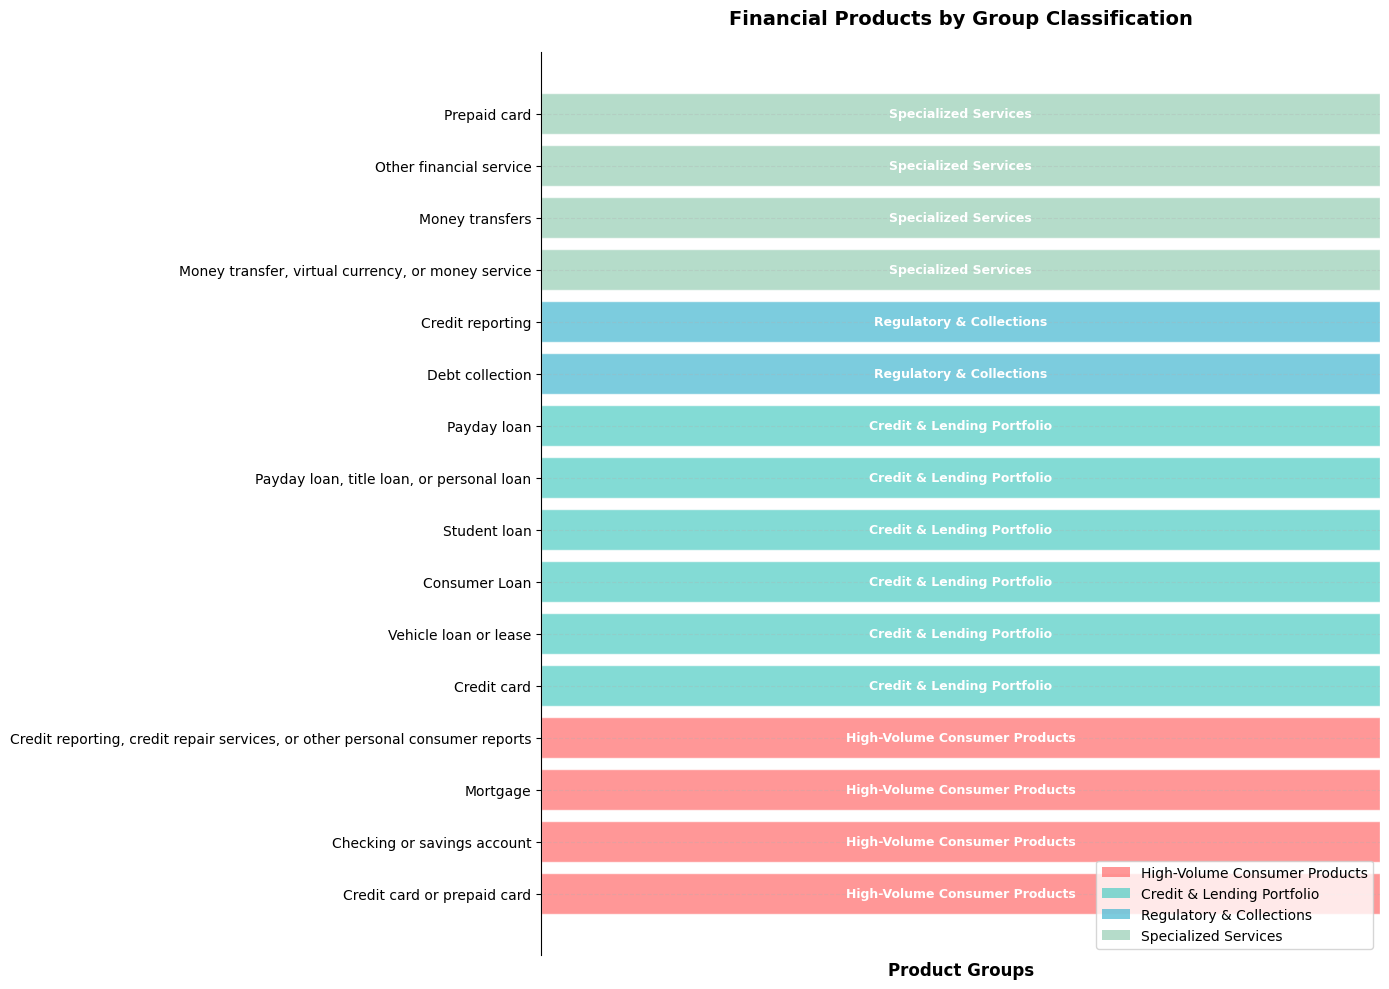

=== PRODUCT GROUPINGS ===

High-Volume Consumer Products:
  • Credit card or prepaid card
  • Checking or savings account
  • Mortgage
  • Credit reporting, credit repair services, or other personal consumer reports
  Total products: 4

Credit & Lending Portfolio:
  • Credit card
  • Vehicle loan or lease
  • Consumer Loan
  • Student loan
  • Payday loan, title loan, or personal loan
  • Payday loan
  Total products: 6

Regulatory & Collections:
  • Debt collection
  • Credit reporting
  Total products: 2

Specialized Services:
  • Money transfer, virtual currency, or money service
  • Money transfers
  • Other financial service
  • Prepaid card
  Total products: 4


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create the dataset
data = {
    'Product_Name': [
        'Credit card or prepaid card', 'Checking or savings account', 'Mortgage',
        'Credit reporting, credit repair services, or other personal consumer reports',
        'Credit card', 'Vehicle loan or lease', 'Consumer Loan', 'Student loan',
        'Payday loan, title loan, or personal loan', 'Payday loan', 'Debt collection',
        'Credit reporting', 'Money transfer, virtual currency, or money service',
        'Money transfers', 'Other financial service', 'Prepaid card'
    ],
    'Group_Name': [
        'High-Volume Consumer Products', 'High-Volume Consumer Products', 'High-Volume Consumer Products',
        'High-Volume Consumer Products', 'Credit & Lending Portfolio', 'Credit & Lending Portfolio',
        'Credit & Lending Portfolio', 'Credit & Lending Portfolio', 'Credit & Lending Portfolio',
        'Credit & Lending Portfolio', 'Regulatory & Collections', 'Regulatory & Collections',
        'Specialized Services', 'Specialized Services', 'Specialized Services', 'Specialized Services'
    ]
}

df = pd.DataFrame(data)

# Create a clean horizontal bar chart showing product-group relationships
fig, ax = plt.subplots(figsize=(14, 10))

# Get unique groups and assign colors
groups = df['Group_Name'].unique()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
group_colors = dict(zip(groups, colors))

# Create bars with colors based on group
y_positions = range(len(df))
bar_colors = [group_colors[group] for group in df['Group_Name']]

bars = ax.barh(y_positions, [1] * len(df), color=bar_colors, alpha=0.7, edgecolor='white', linewidth=1)

# Set labels
ax.set_yticks(y_positions)
ax.set_yticklabels(df['Product_Name'], fontsize=10)
ax.set_xlabel('Product Groups', fontsize=12, fontweight='bold')
ax.set_title('Financial Products by Group Classification', fontsize=14, fontweight='bold', pad=20)

# Remove x-axis ticks and labels since we just want to show grouping
ax.set_xticks([])
ax.set_xlim(0, 1)

# Add group labels on the bars
for i, (bar, group) in enumerate(zip(bars, df['Group_Name'])):
    ax.text(0.5, bar.get_y() + bar.get_height()/2, group,
            ha='center', va='center', fontweight='bold', fontsize=9, color='white')

# Create legend
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, alpha=0.7, label=group)
                  for group, color in group_colors.items()]
ax.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(1, 0))

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Remove spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()

# Print summary of groupings
print("=== PRODUCT GROUPINGS ===")
for group in groups:
    products = df[df['Group_Name'] == group]['Product_Name'].tolist()
    print(f"\n{group}:")
    for product in products:
        print(f"  • {product}")
    print(f"  Total products: {len(products)}")

Complexity analysis visualisation

<ipython-input-1-899d5478ebfa>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x="Complexity_Score", y="Product", data=df_complexity, palette=palette)


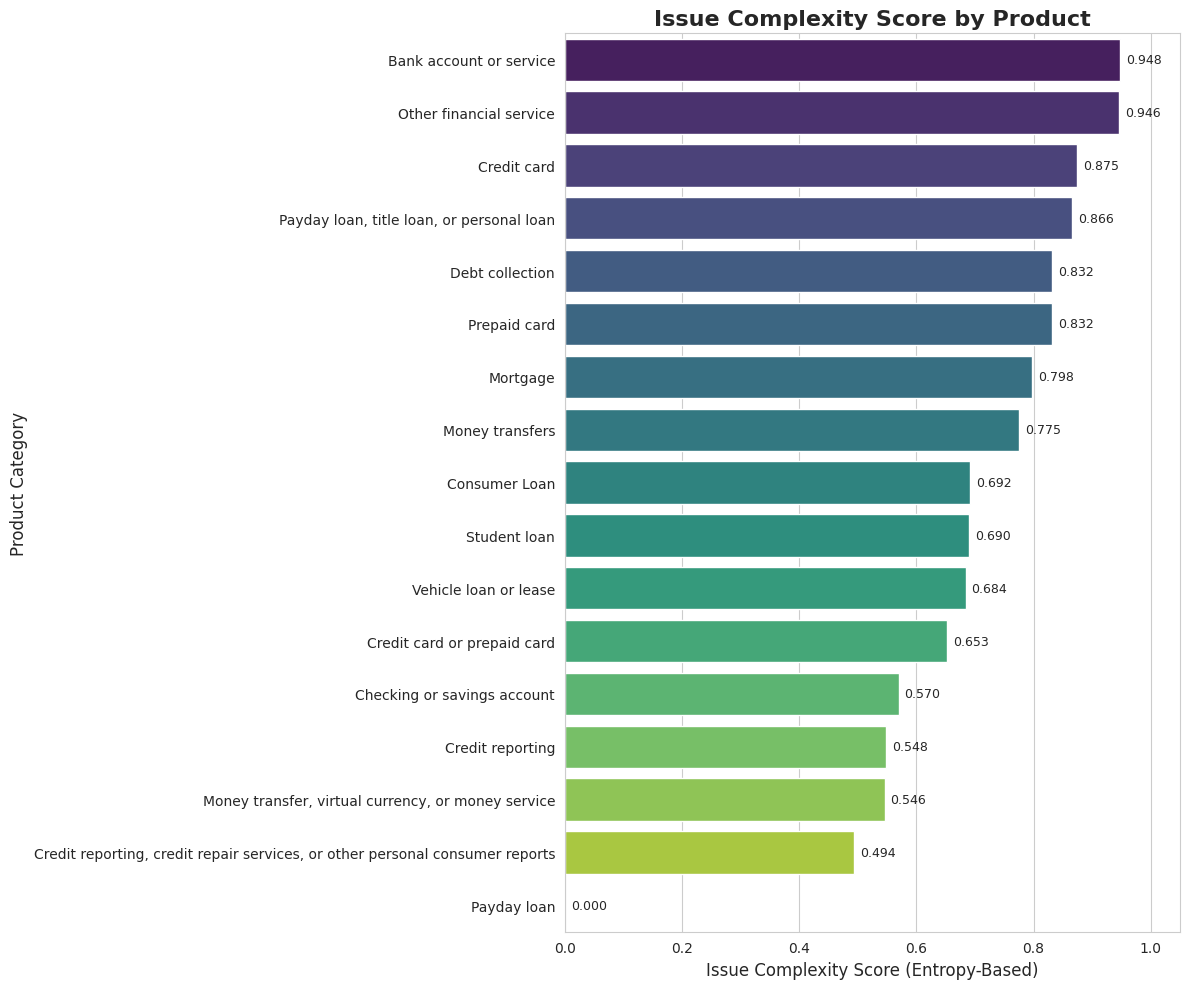

<ipython-input-1-899d5478ebfa>:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_complaints_sorted["Product"], rotation=45, ha="right", fontsize=10)


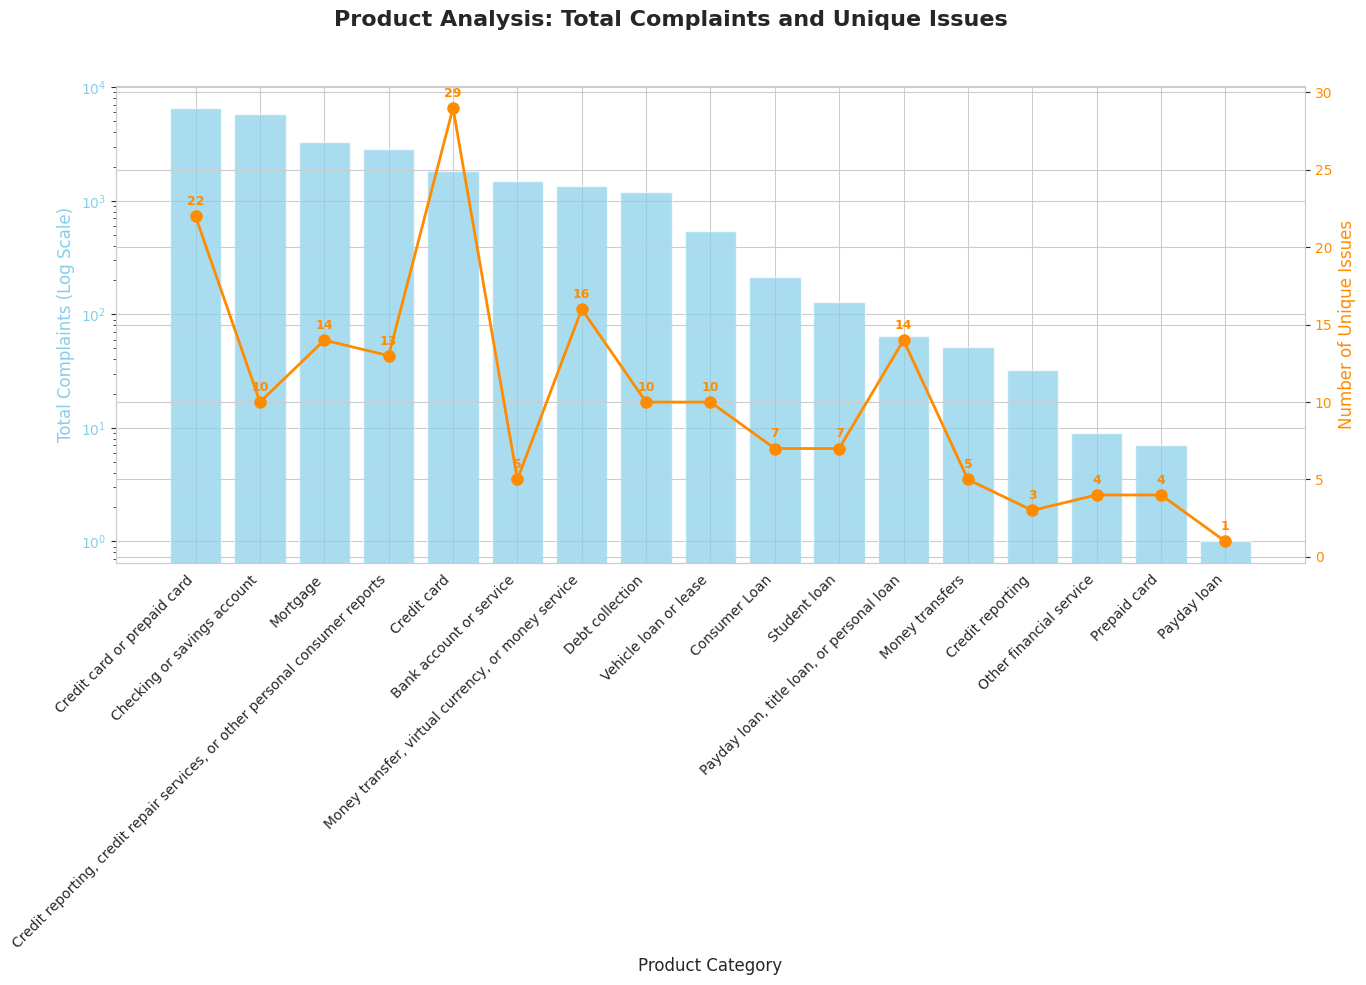

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cell 1: Data Preparation
data = {
    "Product": [
        "Credit card or prepaid card", "Mortgage", "Vehicle loan or lease",
        "Checking or savings account", "Bank account or service",
        "Money transfer, virtual currency, or money service", "Credit card",
        "Credit reporting, credit repair services, or other personal consumer reports",
        "Debt collection", "Student loan", "Payday loan, title loan, or personal loan",
        "Consumer Loan", "Other financial service", "Money transfers",
        "Credit reporting", "Prepaid card", "Payday loan"
    ],
    "Total_Complaints": [
        6566, 3267, 543, 5849, 1487, 1352, 1835, 2876, 1185, 128, 64, 215, 9, 52, 32, 7, 1
    ],
    "Unique_Issues": [
        22, 14, 10, 10, 5, 16, 29, 13, 10, 7, 14, 7, 4, 5, 3, 4, 1
    ],
    "Top_Issue": [
        "Problem with a purchase shown on your statement", "Trouble during payment process",
        "Managing the loan or lease", "Managing an account",
        "Account opening, closing, or management", "Fraud or scam",
        "Billing disputes", "Incorrect information on your report",
        "Attempts to collect debt not owed", "Dealing with my lender or servicer",
        "Problem with the payoff process at the end of the loan",
        "Managing the loan or lease", "Fraud or scam", "Fraud or scam",
        "Incorrect information on credit report", "Fraud or scam",
        "Payment to acct not credited"
    ],
    "Top_Issue_Pct": [
        37.6, 18.6, 34.6, 54.1, 30.6, 58.0, 15.7, 49.3, 36.4, 48.4, 20.3, 46.5, 33.3, 42.3, 81.2, 57.1, 100.0
    ],
    "Complexity_Score": [
        0.653, 0.798, 0.684, 0.570, 0.948, 0.546, 0.875, 0.494, 0.832, 0.690, 0.866, 0.692, 0.946, 0.775, 0.548, 0.832, 0.000
    ]
}

df_complexity = pd.DataFrame(data)

# Sort by complexity score for better visualization
df_complexity = df_complexity.sort_values(by="Complexity_Score", ascending=False)

# Cell 2: Charting - Complexity Score by Product
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

# Create a bar plot for Complexity Score
# Using a color palette that is distinct
palette = sns.color_palette("viridis", len(df_complexity))

barplot = sns.barplot(x="Complexity_Score", y="Product", data=df_complexity, palette=palette)

plt.title('Issue Complexity Score by Product', fontsize=16, fontweight='bold')
plt.xlabel('Issue Complexity Score (Entropy-Based)', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add annotations for the complexity score values on the bars
for i, bar in enumerate(barplot.patches):
    width = bar.get_width()
    plt.text(width + 0.01, # x position (slightly offset from bar end)
             bar.get_y() + bar.get_height() / 2, # y position (center of the bar)
             f'{width:.3f}', # text value (formatted to 3 decimal places)
             ha='left', # horizontal alignment
             va='center', # vertical alignment
             fontsize=9)

plt.xlim(0, 1.05) # Adjust x-limit to make space for text
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Cell 3: Charting - Unique Issues and Total Complaints by Product
# Sort by Total Complaints for this chart
df_complaints_sorted = df_complexity.sort_values(by="Total_Complaints", ascending=False)

fig, ax1 = plt.subplots(figsize=(14, 10))
sns.set_style("whitegrid")

# Bar plot for Total Complaints on primary y-axis
color1 = 'skyblue'
ax1.set_xlabel('Product Category', fontsize=12)
ax1.set_ylabel('Total Complaints (Log Scale)', color=color1, fontsize=12)
bars = ax1.bar(df_complaints_sorted["Product"], df_complaints_sorted["Total_Complaints"], color=color1, label='Total Complaints', alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_yscale('log') # Using log scale due to large variance in complaint numbers
ax1.set_xticklabels(df_complaints_sorted["Product"], rotation=45, ha="right", fontsize=10)


# Create a secondary y-axis for Unique Issues
ax2 = ax1.twinx()
color2 = 'darkorange'
ax2.set_ylabel('Number of Unique Issues', color=color2, fontsize=12)
ax2.plot(df_complaints_sorted["Product"], df_complaints_sorted["Unique_Issues"], color=color2, marker='o', linestyle='-', linewidth=2, markersize=8, label='Unique Issues')
ax2.tick_params(axis='y', labelcolor=color2)

# Add data labels for unique issues
for i, txt in enumerate(df_complaints_sorted["Unique_Issues"]):
    ax2.annotate(txt, (df_complaints_sorted["Product"].iloc[i], df_complaints_sorted["Unique_Issues"].iloc[i]),
                 textcoords="offset points", xytext=(0,8), ha='center', color=color2, fontsize=9, fontweight='bold')


fig.suptitle('Product Analysis: Total Complaints and Unique Issues', fontsize=16, fontweight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.show()

Complaints vs Volume distribution data visualisation


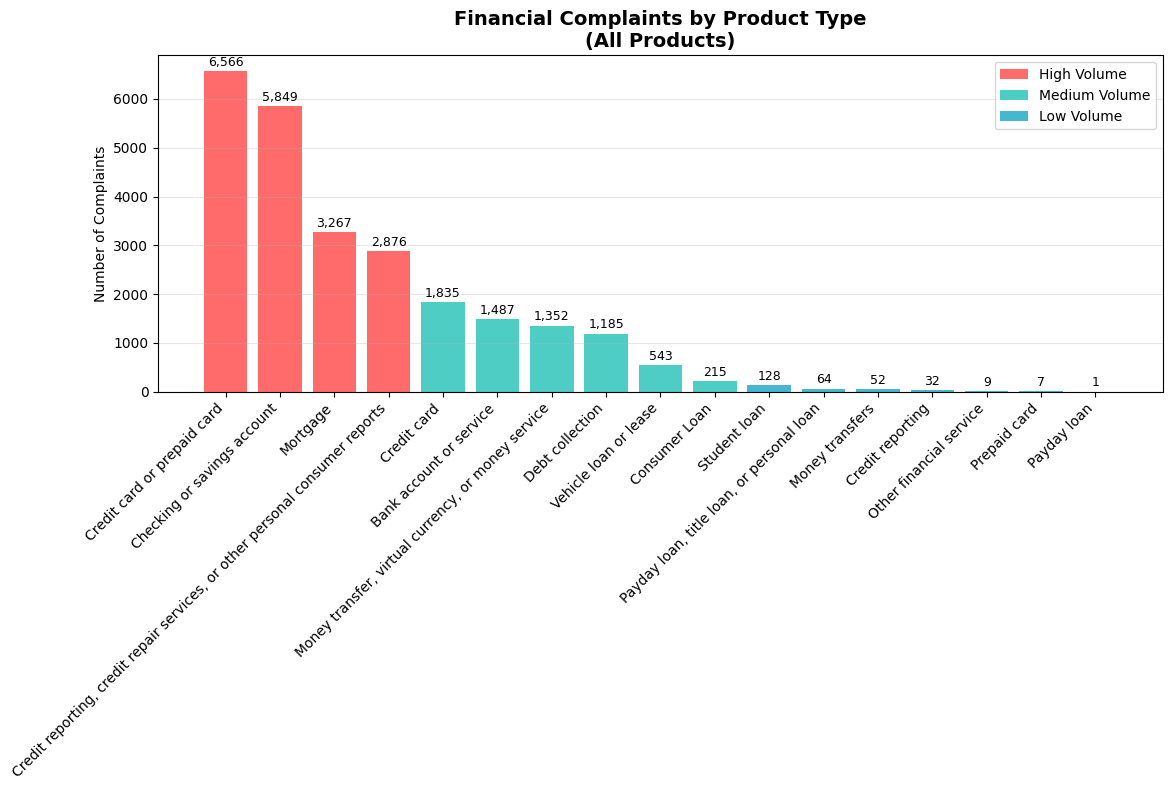

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

# Set up the data
data = {
    # High volume products (>1835 complaints)
    'Credit card or prepaid card': 6566,
    'Checking or savings account': 5849,
    'Mortgage': 3267,
    'Credit reporting, credit repair services, or other personal consumer reports': 2876,

    # Medium volume products (163-1835 complaints)
    'Credit card': 1835,
    'Bank account or service': 1487,
    'Money transfer, virtual currency, or money service': 1352,
    'Debt collection': 1185,
    'Vehicle loan or lease': 543,
    'Consumer Loan': 215,

    # Low volume products (<163 complaints)
    'Student loan': 128,
    'Payday loan, title loan, or personal loan': 64,
    'Money transfers': 52,
    'Credit reporting': 32,
    'Other financial service': 9,
    'Prepaid card': 7,
    'Payday loan': 1
}

# Create DataFrame
df = pd.DataFrame(list(data.items()), columns=['Product', 'Complaints'])
df = df.sort_values('Complaints', ascending=False)

# Define volume tiers
def get_tier(complaints):
    if complaints > 1835:
        return 'High Volume'
    elif 163 <= complaints <= 1835:
        return 'Medium Volume'
    else:
        return 'Low Volume'

df['Tier'] = df['Complaints'].apply(get_tier)
df['Market_Share'] = (df['Complaints'] / df['Complaints'].sum()) * 100


# Color scheme
colors = {
    'High Volume': '#FF6B6B',   # Red
    'Medium Volume': '#4ECDC4',  # Teal
    'Low Volume': '#45B7D1'    # Blue
}

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create legend elements once
legend_elements = [Patch(facecolor=colors[tier], label=tier) for tier in colors.keys()]

# --- Plot 1: Overview Bar Chart (All Products) ---
plt.figure(figsize=(12, 8)) # Adjusted figsize for single plot
bars = plt.bar(range(len(df)), df['Complaints'],
               color=[colors[tier] for tier in df['Tier']])
plt.xticks(range(len(df)), df['Product'], rotation=45, ha='right')
plt.ylabel('Number of Complaints')
plt.title('Financial Complaints by Product Type\n(All Products)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height):,}', ha='center', va='bottom', fontsize=9)

plt.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

NLP to predict groups of the product using TF-IDF & Logistic Regression

UMBANK INTEGRATED COMPLAINT CLASSIFIER CONFIGURATION
Model Configuration:
  csv_file_path: /content/cleaned_UMBank_complaints_data.csv
  max_rows: 27972
  use_strategic_groups: True
  use_original_products: False
  test_size: 0.2
  output_dir: ./umbank_integrated_classifier
  random_state: 42
  tfidf_max_features: 5000
  tfidf_ngram_range: (1, 2)
  logistic_C: 1.0
  logistic_solver: liblinear
  min_complaint_length: 10
  train_dual_models: True

Strategic Groups (5 groups):
  High-Volume Consumer Products:
     Products: 4
     Expected Volume: 20280
     Priority: Critical
  Credit & Lending Portfolio:
     Products: 6
     Expected Volume: 3112
     Priority: High
  Regulatory & Collections:
     Products: 2
     Expected Volume: 1365
     Priority: High
  Specialized Services:
     Products: 4
     Expected Volume: 1565
     Priority: Medium
  Banking Services:
     Products: 1
     Expected Volume: N/A
     Priority: N/A
-------------------------------------------------------------

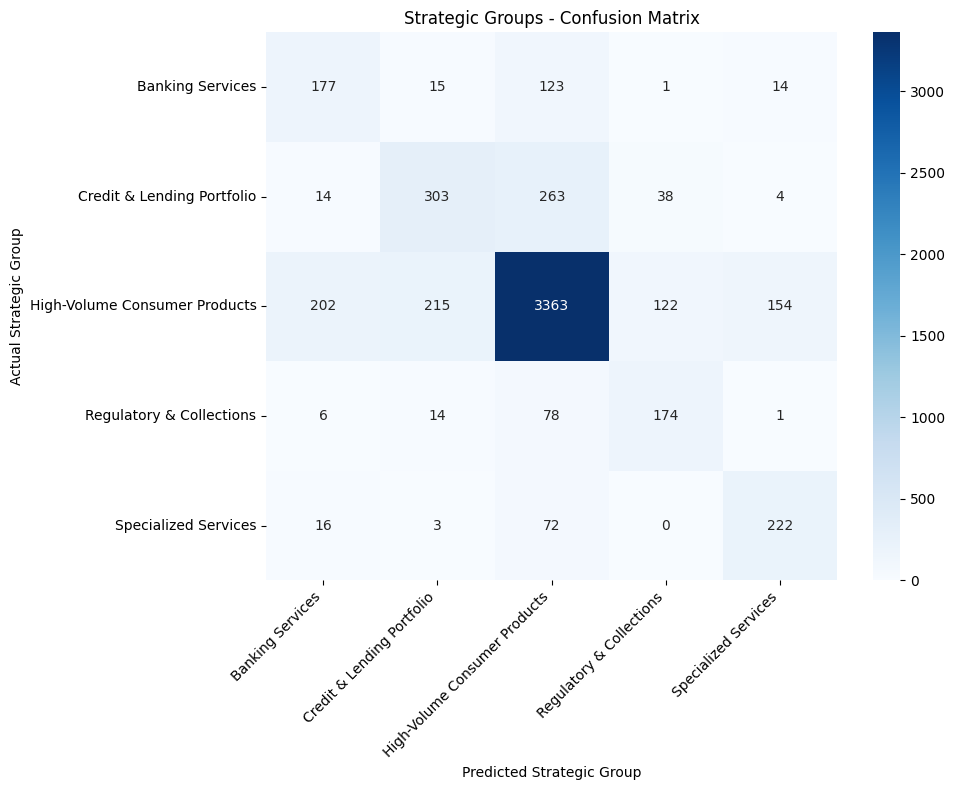

   Product confusion matrix saved (too large to display: 17 classes)


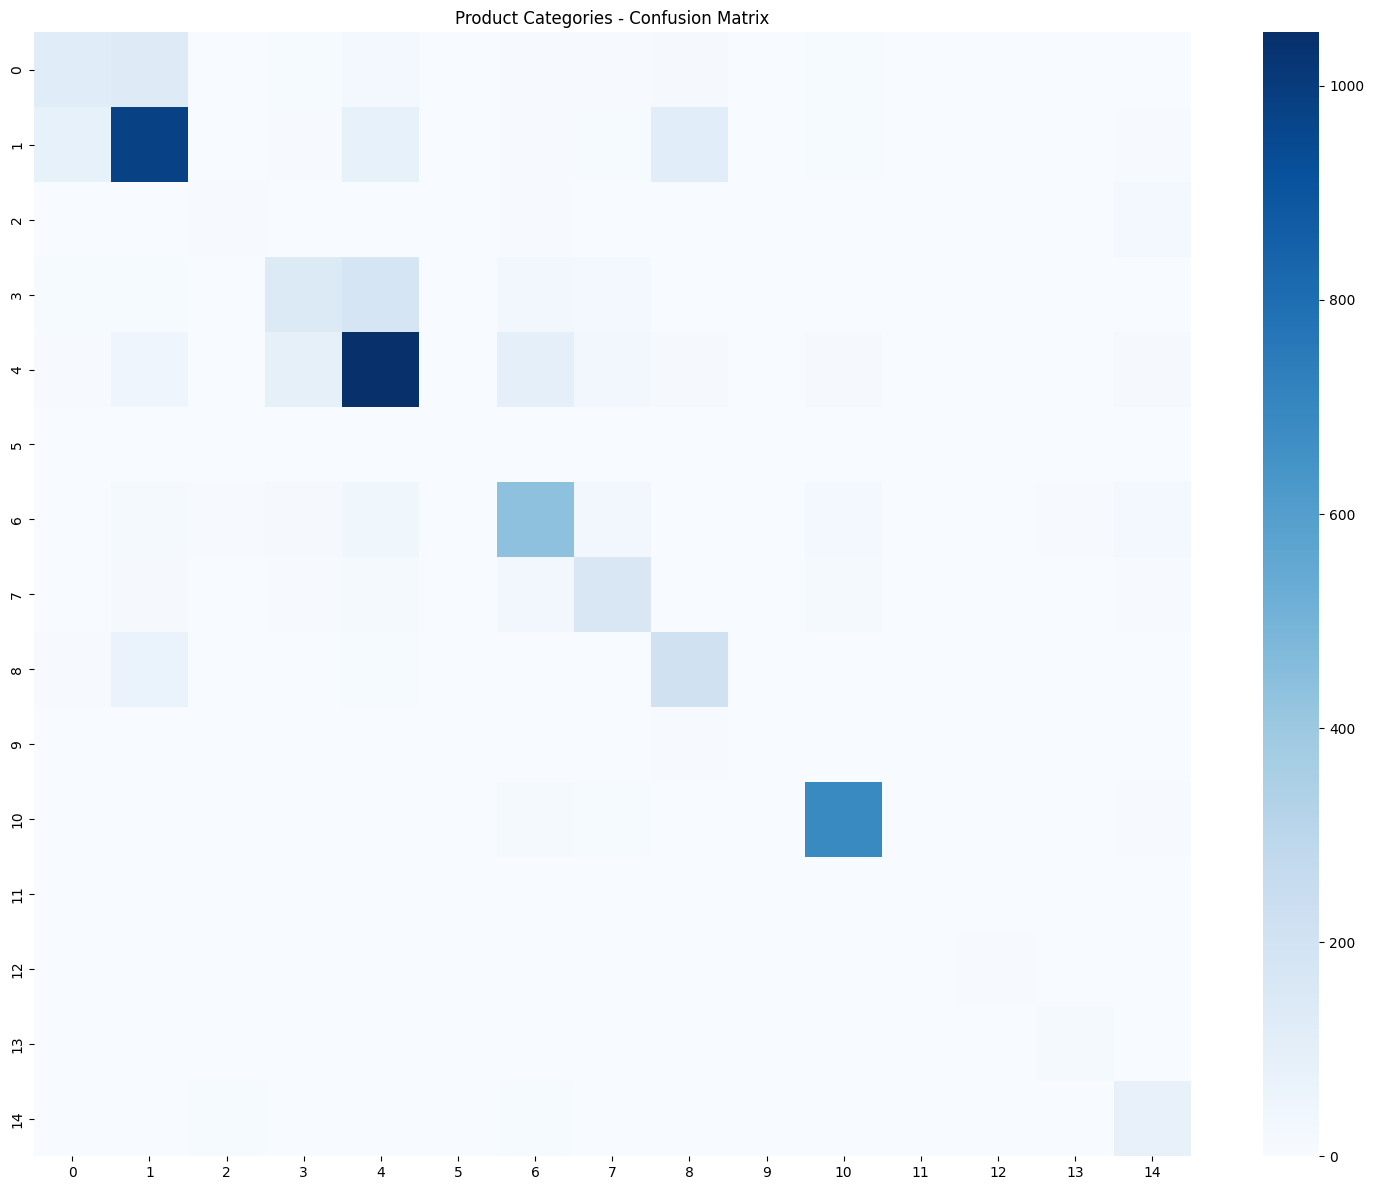


Saving integrated classifier artifacts...
   Strategic model: ./umbank_integrated_classifier/strategic_model_pipeline.joblib
   Product model: ./umbank_integrated_classifier/product_model_pipeline.joblib
   Strategic encoder: ./umbank_integrated_classifier/strategic_label_encoder.joblib
   Product encoder: ./umbank_integrated_classifier/product_label_encoder.joblib
   Configuration: ./umbank_integrated_classifier/model_configuration.json
   Statistics: ./umbank_integrated_classifier/training_statistics.json

INTEGRATED COMPLAINT PREDICTION DEMO

Complaint 1:
   Text: My credit card was charged twice for the same transaction and I need this fixed immediately
Strategic Group: High-Volume Consumer Products
Confidence: 69.41%
 Specific Product: Credit card or prepaid card
Product Confidence: 54.80%
Strategy: Dedicated high-capacity teams with streamlined processes
Priority: Critical
Routing: High-Volume Consumer Products
Escalation Needed: True
--------------------------------------------

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from datetime import datetime
import warnings
import re
import json

CONFIG = {
    'csv_file_path': '/content/cleaned_UMBank_complaints_data.csv',
    'max_rows': 27972,
    'use_strategic_groups': True,
    'use_original_products': False,
    'test_size': 0.2,
    'output_dir': './umbank_integrated_classifier',
    'random_state': 42,
    'tfidf_max_features': 5000,
    'tfidf_ngram_range': (1, 2),
    'logistic_C': 1.0,
    'logistic_solver': 'liblinear',
    'min_complaint_length': 10,
    'train_dual_models': True
}

STRATEGIC_GROUPS_CONFIG = {
    'High-Volume Consumer Products': [
        'Credit card or prepaid card',
        'Checking or savings account',
        'Mortgage',
        'Credit reporting, credit repair services, or other personal consumer reports'
    ],
    'Credit & Lending Portfolio': [
        'Credit card',
        'Vehicle loan or lease',
        'Consumer Loan',
        'Student loan',
        'Payday loan, title loan, or personal loan',
        'Payday loan'
    ],
    'Regulatory & Collections': [
        'Debt collection',
        'Credit reporting'
    ],
    'Specialized Services': [
        'Money transfer, virtual currency, or money service',
        'Money transfers',
        'Other financial service',
        'Prepaid card'
    ],
    'Banking Services': [
        'Bank account or service'
    ]
}

BUSINESS_METRICS = {
    'volume_thresholds': {
        'high': 2070,
        'medium_min': 180,
        'low_max': 180
    },
    'strategic_insights': {
        'High-Volume Consumer Products': {
            'total_complaints': 20280,
            'avg_per_product': 5070,
            'strategy': 'Dedicated high-capacity teams with streamlined processes',
            'priority': 'Critical'
        },
        'Credit & Lending Portfolio': {
            'total_complaints': 3112,
            'avg_per_product': 519,
            'strategy': 'Specialized lending team with risk management focus',
            'priority': 'High'
        },
        'Regulatory & Collections': {
            'total_complaints': 1365,
            'avg_per_product': 682,
            'strategy': 'Compliance-focused team with legal support',
            'priority': 'High'
        },
        'Specialized Services': {
            'total_complaints': 1565,
            'avg_per_product': 391,
            'strategy': 'Technical specialists for transaction-based services',
            'priority': 'Medium'
        }
    }
}

warnings.filterwarnings('ignore')
np.random.seed(CONFIG['random_state'])

def print_enhanced_config(config, strategic_config, business_metrics):
    """Prints enhanced configuration with strategic insights."""
    print("=" * 70)
    print("UMBANK INTEGRATED COMPLAINT CLASSIFIER CONFIGURATION")
    print("=" * 70)
    print("Model Configuration:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    print(f"\nStrategic Groups ({len(strategic_config)} groups):")
    for group, products in strategic_config.items():
        metrics = business_metrics['strategic_insights'].get(group, {})
        print(f"  {group}:")
        print(f"     Products: {len(products)}")
        print(f"     Expected Volume: {metrics.get('total_complaints', 'N/A')}")
        print(f"     Priority: {metrics.get('priority', 'N/A')}")
    print("-" * 70)

def load_and_validate_data(file_path, max_rows=None, random_state=42):
    """Enhanced data loading with validation against expected structure."""
    print(f"Loading UMBank complaint data from {file_path}...")
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded: {df.shape}")

        required_columns = ['Complaint', 'Product']
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

        if max_rows and len(df) > max_rows:
            df = df.sample(n=max_rows, random_state=random_state).reset_index(drop=True)
            print(f"Using {len(df)} rows (sampled from full dataset)")

        print(f"Total complaints to process: {len(df):,}")
        return df

    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        raise
    except Exception as e:
        print(f"Data loading error: {e}")
        raise

def clean_complaint_text_enhanced(df, min_length):
    """Enhanced complaint text cleaning with better preprocessing."""
    print(f"\nCleaning complaint text (min length: {min_length} chars)...")

    if 'Complaint' not in df.columns:
        raise ValueError("'Complaint' column not found in DataFrame.")

    df_cleaned = df.copy()

    # Enhanced text cleaning
    df_cleaned['Complaint'] = df_cleaned['Complaint'].astype(str)
    df_cleaned['Complaint'] = df_cleaned['Complaint'].str.lower()
    df_cleaned['Complaint'] = df_cleaned['Complaint'].apply(
        lambda x: re.sub(r'\s+', ' ', x.strip())
    )
    df_cleaned['Complaint'] = df_cleaned['Complaint'].apply(
        lambda x: re.sub(r'x{2,}', '', x)  # Remove redactions
    )
    df_cleaned['Complaint'] = df_cleaned['Complaint'].apply(
        lambda x: re.sub(r'[^\w\s]', ' ', x)  # Remove special characters
    )

    # Remove short complaints
    initial_rows = len(df_cleaned)
    df_cleaned = df_cleaned[df_cleaned['Complaint'].str.len() >= min_length]
    removed_short = initial_rows - len(df_cleaned)

    # Remove empty complaints
    df_cleaned = df_cleaned[df_cleaned['Complaint'].str.strip().astype(bool)]
    final_rows = len(df_cleaned)

    print(f"   Removed {removed_short} complaints shorter than {min_length} chars")
    print(f"   Final dataset: {final_rows:,} complaints")

    if final_rows == 0:
        raise ValueError("No complaints remaining after cleaning.")

    print(f"\nSample cleaned complaints:")
    for i, complaint in enumerate(df_cleaned['Complaint'].head(3)):
        print(f"   {i+1}. {complaint[:80]}...")

    return df_cleaned

def apply_strategic_grouping(df, strategic_groups_config):
    """Apply strategic business grouping to products."""
    print(f"\nApplying strategic business grouping...")

    product_to_group = {}
    for group, products in strategic_groups_config.items():
        for product in products:
            product_to_group[product] = group

    df_grouped = df.copy()
    df_grouped['Strategic_Group'] = df_grouped['Product'].map(product_to_group)

    unmapped = df_grouped['Strategic_Group'].isnull().sum()
    if unmapped > 0:
        print(f"   Warning: {unmapped} complaints with unmapped products")
        unmapped_products = df_grouped[df_grouped['Strategic_Group'].isnull()]['Product'].unique()
        print(f"   Unmapped products: {list(unmapped_products)}")
        df_grouped = df_grouped.dropna(subset=['Strategic_Group'])

    group_dist = df_grouped['Strategic_Group'].value_counts()
    print(f"\nStrategic Group Distribution:")
    for group, count in group_dist.items():
        expected = BUSINESS_METRICS['strategic_insights'].get(group, {}).get('total_complaints', 'N/A')
        print(f"   {group}: {count:,} complaints (expected: {expected})")

    print(f"Total classified: {len(df_grouped):,} complaints")
    return df_grouped

def prepare_dual_targets(df, strategic_groups_config):
    """Prepare both strategic group and product-level targets."""
    print(f"\nPreparing dual classification targets...")

    # Apply strategic grouping
    df_strategic = apply_strategic_grouping(df, strategic_groups_config)

    strategic_encoder = LabelEncoder()
    df_strategic['strategic_labels'] = strategic_encoder.fit_transform(df_strategic['Strategic_Group'])

    product_encoder = LabelEncoder()
    df_strategic['product_labels'] = product_encoder.fit_transform(df_strategic['Product'])

    print(f"Strategic groups: {len(strategic_encoder.classes_)} classes")
    print(f"Product categories: {len(product_encoder.classes_)} classes")

    return df_strategic, strategic_encoder, product_encoder

def build_dual_models(config):
    """Build both strategic and product-level model pipelines."""
    print(f"\nBuilding dual model pipelines...")

    # Strategic group model
    strategic_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=config['tfidf_max_features'],
            stop_words='english',
            ngram_range=config['tfidf_ngram_range']
        )),
        ('clf', LogisticRegression(
            random_state=config['random_state'],
            solver=config['logistic_solver'],
            C=config['logistic_C'],
            class_weight='balanced'
        ))
    ])

    # Product-level model
    product_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=config['tfidf_max_features'],
            stop_words='english',
            ngram_range=config['tfidf_ngram_range']
        )),
        ('clf', LogisticRegression(
            random_state=config['random_state'],
            solver=config['logistic_solver'],
            C=config['logistic_C'],
            class_weight='balanced'
        ))
    ])

    print(f"   Strategic group pipeline created")
    print(f"   Product-level pipeline created")

    return strategic_pipeline, product_pipeline

def train_dual_models(strategic_model, product_model, X_train, y_strategic_train, y_product_train):
    """Train both strategic and product-level models."""
    print(f"\nTraining dual models...")
    start_time = datetime.now()

    # Train strategic model
    print(f"   Training strategic group classifier...")
    strategic_model.fit(X_train, y_strategic_train)

    # Train product model
    print(f"   Training product-level classifier...")
    product_model.fit(X_train, y_product_train)

    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()

    print(f"   Dual training completed in {training_time:.2f} seconds")
    return strategic_model, product_model, training_time

def evaluate_dual_models(strategic_model, product_model, X_test, y_strategic_test, y_product_test,
                        strategic_encoder, product_encoder, output_dir):
    """Evaluate both models and generate comprehensive reports."""
    print(f"\nEvaluating dual models...")

    # Strategic model evaluation
    y_strategic_pred = strategic_model.predict(X_test)
    strategic_accuracy = accuracy_score(y_strategic_test, y_strategic_pred)
    strategic_f1 = f1_score(y_strategic_test, y_strategic_pred, average='weighted')

    # Product model evaluation
    y_product_pred = product_model.predict(X_test)
    product_accuracy = accuracy_score(y_product_test, y_product_pred)
    product_f1 = f1_score(y_product_test, y_product_pred, average='weighted')

    print(f"\nSTRATEGIC GROUP MODEL RESULTS:")
    print(f"   Accuracy: {strategic_accuracy:.4f} ({strategic_accuracy*100:.2f}%)")
    print(f"   F1-Score: {strategic_f1:.4f}")
    print(f"   Classes: {len(strategic_encoder.classes_)}")

    print(f"\nPRODUCT-LEVEL MODEL RESULTS:")
    print(f"   Accuracy: {product_accuracy:.4f} ({product_accuracy*100:.2f}%)")
    print(f"   F1-Score: {product_f1:.4f}")
    print(f"   Classes: {len(product_encoder.classes_)}")

    # Generate confusion matrices
    os.makedirs(output_dir, exist_ok=True)

    # Strategic confusion matrix
    strategic_cm = confusion_matrix(y_strategic_test, y_strategic_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(strategic_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=strategic_encoder.classes_,
                yticklabels=strategic_encoder.classes_)
    plt.title('Strategic Groups - Confusion Matrix')
    plt.xlabel('Predicted Strategic Group')
    plt.ylabel('Actual Strategic Group')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    strategic_cm_path = os.path.join(output_dir, "strategic_confusion_matrix.png")
    plt.savefig(strategic_cm_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Product confusion matrix (top 10 products only for readability)
    product_cm = confusion_matrix(y_product_test, y_product_pred)
    if len(product_encoder.classes_) > 10:
        print(f"   Product confusion matrix saved (too large to display: {len(product_encoder.classes_)} classes)")
        product_cm_path = os.path.join(output_dir, "product_confusion_matrix.png")
        plt.figure(figsize=(15, 12))
        sns.heatmap(product_cm, annot=False, cmap='Blues')
        plt.title('Product Categories - Confusion Matrix')
        plt.tight_layout()
        plt.savefig(product_cm_path, dpi=300, bbox_inches='tight')
        plt.show()
    else:
        plt.figure(figsize=(12, 10))
        sns.heatmap(product_cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=product_encoder.classes_,
                    yticklabels=product_encoder.classes_)
        plt.title('Product Categories - Confusion Matrix')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        product_cm_path = os.path.join(output_dir, "product_confusion_matrix.png")
        plt.savefig(product_cm_path, dpi=300, bbox_inches='tight')
        plt.show()

    return {
        'strategic_accuracy': strategic_accuracy,
        'strategic_f1': strategic_f1,
        'product_accuracy': product_accuracy,
        'product_f1': product_f1,
        'strategic_cm_path': strategic_cm_path,
        'product_cm_path': product_cm_path
    }

def save_integrated_artifacts(strategic_model, product_model, strategic_encoder, product_encoder,
                            training_stats, output_dir):
    """Save all models and artifacts."""
    print(f"\nSaving integrated classifier artifacts...")
    os.makedirs(output_dir, exist_ok=True)

    # Save models
    strategic_model_path = os.path.join(output_dir, "strategic_model_pipeline.joblib")
    product_model_path = os.path.join(output_dir, "product_model_pipeline.joblib")
    strategic_encoder_path = os.path.join(output_dir, "strategic_label_encoder.joblib")
    product_encoder_path = os.path.join(output_dir, "product_label_encoder.joblib")

    joblib.dump(strategic_model, strategic_model_path)
    joblib.dump(product_model, product_model_path)
    joblib.dump(strategic_encoder, strategic_encoder_path)
    joblib.dump(product_encoder, product_encoder_path)

    # Save configuration and stats
    config_path = os.path.join(output_dir, "model_configuration.json")
    stats_path = os.path.join(output_dir, "training_statistics.json")

    # Enhanced configuration with strategic insights
    full_config = {
        'model_config': CONFIG,
        'strategic_groups': STRATEGIC_GROUPS_CONFIG,
        'business_metrics': BUSINESS_METRICS,
        'training_stats': training_stats
    }

    with open(config_path, 'w') as f:
        json.dump(full_config, f, indent=2, default=str)

    with open(stats_path, 'w') as f:
        json.dump(training_stats, f, indent=2, default=str)

    print(f"   Strategic model: {strategic_model_path}")
    print(f"   Product model: {product_model_path}")
    print(f"   Strategic encoder: {strategic_encoder_path}")
    print(f"   Product encoder: {product_encoder_path}")
    print(f"   Configuration: {config_path}")
    print(f"   Statistics: {stats_path}")

    return {
        'strategic_model_path': strategic_model_path,
        'product_model_path': product_model_path,
        'strategic_encoder_path': strategic_encoder_path,
        'product_encoder_path': product_encoder_path,
        'config_path': config_path,
        'stats_path': stats_path
    }

class IntegratedComplaintPredictor:
    """Integrated predictor that provides both strategic and product-level predictions."""

    def __init__(self, strategic_model, product_model, strategic_encoder, product_encoder):
        self.strategic_model = strategic_model
        self.product_model = product_model
        self.strategic_encoder = strategic_encoder
        self.product_encoder = product_encoder

    def predict_complaint(self, complaint_text):
        """Predict both strategic group and specific product for a complaint."""
        # Clean the input
        cleaned_text = self._clean_text(complaint_text)

        # Strategic prediction
        strategic_probs = self.strategic_model.predict_proba([cleaned_text])[0]
        strategic_pred_idx = np.argmax(strategic_probs)
        strategic_group = self.strategic_encoder.classes_[strategic_pred_idx]
        strategic_confidence = strategic_probs[strategic_pred_idx]

        # Product prediction
        product_probs = self.product_model.predict_proba([cleaned_text])[0]
        product_pred_idx = np.argmax(product_probs)
        product = self.product_encoder.classes_[product_pred_idx]
        product_confidence = product_probs[product_pred_idx]

        # Get business insights
        business_insight = BUSINESS_METRICS['strategic_insights'].get(strategic_group, {})

        return {
            'strategic_prediction': {
                'group': strategic_group,
                'confidence': strategic_confidence,
                'strategy': business_insight.get('strategy', 'N/A'),
                'priority': business_insight.get('priority', 'N/A')
            },
            'product_prediction': {
                'product': product,
                'confidence': product_confidence
            },
            'recommendation': self._get_routing_recommendation(strategic_group, product, strategic_confidence)
        }

    def _clean_text(self, text):
        """Clean input text to match training preprocessing."""
        cleaned = str(text).lower().strip()
        cleaned = re.sub(r'\s+', ' ', cleaned)
        cleaned = re.sub(r'x{2,}', '', cleaned)
        cleaned = re.sub(r'[^\w\s]', ' ', cleaned)
        return cleaned

    def _get_routing_recommendation(self, strategic_group, product, confidence):
        """Provide routing recommendation based on predictions."""
        if confidence > 0.8:
            confidence_level = "High"
        elif confidence > 0.6:
            confidence_level = "Medium"
        else:
            confidence_level = "Low"

        insights = BUSINESS_METRICS['strategic_insights'].get(strategic_group, {})
        priority = insights.get('priority', 'Medium')

        return {
            'confidence_level': confidence_level,
            'routing_priority': priority,
            'suggested_team': strategic_group,
            'escalation_needed': confidence < 0.6 or priority == 'Critical'
        }

def run_integrated_demo(predictor):
    """Run demonstration of the integrated prediction system."""
    print(f"\n" + "="*70)
    print(f"INTEGRATED COMPLAINT PREDICTION DEMO")
    print(f"="*70)

    demo_complaints = [
        "My credit card was charged twice for the same transaction and I need this fixed immediately",
        "I can't access my online banking account and this is really frustrating",
        "The ATM ate my card and won't give it back to me",
        "I applied for a mortgage but haven't heard back for weeks",
        "There are unauthorized charges on my account statement again",
        "Debt collector keeps calling me at work even though I don't owe this money",
        "My student loan payment was not processed correctly this month",
        "Someone used my identity to open a bank account without my permission",
        "The money transfer I sent never arrived at the destination",
        "I'm having trouble with my vehicle loan payment process"
    ]

    for i, complaint in enumerate(demo_complaints, 1):
        print(f"\nComplaint {i}:")
        print(f"   Text: {complaint}")

        try:
            result = predictor.predict_complaint(complaint)

            print(f"Strategic Group: {result['strategic_prediction']['group']}")
            print(f"Confidence: {result['strategic_prediction']['confidence']:.2%}")
            print(f" Specific Product: {result['product_prediction']['product']}")
            print(f"Product Confidence: {result['product_prediction']['confidence']:.2%}")
            print(f"Strategy: {result['strategic_prediction']['strategy']}")
            print(f"Priority: {result['strategic_prediction']['priority']}")
            print(f"Routing: {result['recommendation']['suggested_team']}")
            print(f"Escalation Needed: {result['recommendation']['escalation_needed']}")

        except Exception as e:
            print(f"Prediction error: {e}")

        print("-" * 50)

def display_integrated_summary(training_stats, file_paths):
    """Display comprehensive summary of the integrated system."""
    print(f"\n" + "="*70)
    print(f"UMBANK INTEGRATED CLASSIFIER - TRAINING COMPLETE")
    print(f"="*70)

    print(f"DATASET SUMMARY:")
    print(f"   • Total samples processed: {training_stats.get('total_samples', 'N/A'):,}")
    print(f"   • Training samples: {training_stats.get('training_samples', 'N/A'):,}")
    print(f"   • Test samples: {training_stats.get('test_samples', 'N/A'):,}")
    print(f"   • Training time: {training_stats.get('training_time', 0):.2f} seconds")

    print(f"\nMODEL PERFORMANCE:")
    print(f"   Strategic Groups Model:")
    print(f"     • Accuracy: {training_stats.get('strategic_accuracy', 0):.2%}")
    print(f"     • F1-Score: {training_stats.get('strategic_f1', 0):.4f}")
    print(f"     • Classes: {training_stats.get('strategic_classes', 'N/A')}")

    print(f"Product-Level Model:")
    print(f"     • Accuracy: {training_stats.get('product_accuracy', 0):.2%}")
    print(f"     • F1-Score: {training_stats.get('product_f1', 0):.4f}")
    print(f"     • Classes: {training_stats.get('product_classes', 'N/A')}")

    print(f"\nBUSINESS INSIGHTS:")
    for group, metrics in BUSINESS_METRICS['strategic_insights'].items():
        print(f"   {group}:")
        print(f"     • Expected Volume: {metrics['total_complaints']:,}")
        print(f"     • Strategy: {metrics['strategy']}")
        print(f"     • Priority: {metrics['priority']}")

    print(f"\nSAVED ARTIFACTS:")
    for key, path in file_paths.items():
        print(f"   • {key.replace('_', ' ').title()}: {path}")

    print(f"\nNEXT STEPS:")
    print(f"   1. Load models using joblib.load() for production use")
    print(f"   2. Use IntegratedComplaintPredictor for real-time predictions")
    print(f"   3. Implement routing logic based on strategic group predictions")
    print(f"   4. Monitor model performance and retrain periodically")
    print(f"   5. Integrate with customer service workflow systems")

def main():
    """Main function to run the integrated complaint classification system."""

    print_enhanced_config(CONFIG, STRATEGIC_GROUPS_CONFIG, BUSINESS_METRICS)

    # 1. Load and prepare data
    raw_df = load_and_validate_data(CONFIG['csv_file_path'], CONFIG.get('max_rows'), CONFIG['random_state'])
    df = raw_df[['Complaint', 'Product']].copy()

    # 2. Clean and preprocess
    df_cleaned = clean_complaint_text_enhanced(df, CONFIG['min_complaint_length'])

    # 3. Prepare dual targets
    df_final, strategic_encoder, product_encoder = prepare_dual_targets(df_cleaned, STRATEGIC_GROUPS_CONFIG)

    # 4. Prepare features and split data
    X = df_final['Complaint']
    y_strategic = df_final['strategic_labels']
    y_product = df_final['product_labels']

    X_train, X_test, y_strategic_train, y_strategic_test, y_product_train, y_product_test = train_test_split(
        X, y_strategic, y_product,
        test_size=CONFIG['test_size'],
        random_state=CONFIG['random_state'],
        stratify=y_strategic  # Stratify on strategic groups
    )

    print(f"\nData Split Summary:")
    print(f"   Training: {len(X_train):,} samples")
    print(f"   Testing: {len(X_test):,} samples")

    # 5. Build and train models
    strategic_model, product_model = build_dual_models(CONFIG)
    strategic_model, product_model, training_time = train_dual_models(
        strategic_model, product_model, X_train, y_strategic_train, y_product_train
    )

    # 6. Evaluate models
    evaluation_results = evaluate_dual_models(
        strategic_model, product_model, X_test, y_strategic_test, y_product_test,
        strategic_encoder, product_encoder, CONFIG['output_dir']
    )

    # 7. Prepare training statistics
    training_stats = {
        'training_date': datetime.now().isoformat(),
        'total_samples': len(df_final),
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'strategic_classes': len(strategic_encoder.classes_),
        'product_classes': len(product_encoder.classes_),
        'training_time': training_time,
        **evaluation_results
    }

    # 8. Save artifacts
    file_paths = save_integrated_artifacts(
        strategic_model, product_model, strategic_encoder, product_encoder,
        training_stats, CONFIG['output_dir']
    )

    # 9. Create integrated predictor and run demo
    predictor = IntegratedComplaintPredictor(
        strategic_model, product_model, strategic_encoder, product_encoder
    )
    run_integrated_demo(predictor)

    # 10. Display final summary
    display_integrated_summary(training_stats, file_paths)

    return predictor, training_stats, file_paths

if __name__ == "__main__":
    try:
        predictor, stats, paths = main()
        print(f"\nIntegration successful! Predictor ready for use.")
    except Exception as e:
        print(f"\nIntegration failed: {e}")
        import traceback
        traceback.print_exc()

Sentiment analysis using 2 BERT transformer based model

In [ ]:
import torch
from transformers import pipeline
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class DualModelSentimentAnalyzer:
    def __init__(self):
        """Initialize the dual-model sentiment analyzer"""
        print("Initializing Dual-Model Sentiment Analyzer...")
        print("-" * 50)

        # Check if CUDA is available
        self.device = 0 if torch.cuda.is_available() else -1
        print(f"Using device: {'GPU' if self.device == 0 else 'CPU'}")

        # Load Model 1: DistilBERT
        print("\nLoading Model 1 (DistilBERT)...")
        try:
            self.model1 = pipeline(
                "sentiment-analysis",
                model="distilbert-base-uncased-finetuned-sst-2-english",
                device=self.device
            )
            print("✓ Model 1 loaded successfully!")
        except Exception as e:
            print(f"Error loading Model 1: {e}")
            print("Using default sentiment model...")
            self.model1 = pipeline("sentiment-analysis", device=self.device)

        # Load Model 2: Alternative model
        print("\nLoading Model 2 (BERT-based)...")
        try:
            # Try RoBERTa first
            self.model2 = pipeline(
                "sentiment-analysis",
                model="cardiffnlp/twitter-roberta-base-sentiment-latest",
                device=self.device
            )
            print("✓ Model 2 (RoBERTa) loaded successfully!")
        except:
            try:
                # Fallback to BERTweet
                self.model2 = pipeline(
                    "sentiment-analysis",
                    model="finiteautomata/bertweet-base-sentiment-analysis",
                    device=self.device
                )
                print("✓ Model 2 (BERTweet) loaded successfully!")
            except:
                # Final fallback
                print("Using alternative model for Model 2...")
                self.model2 = pipeline(
                    "sentiment-analysis",
                    model="nlptown/bert-base-multilingual-uncased-sentiment",
                    device=self.device
                )

        print("\n✓ Both models loaded and ready!")
        print("-" * 50)

    def convert_to_score(self, result):
        """Convert sentiment labels to numerical scores (-1 to 1)"""
        label = result['label'].lower()
        score = result['score']

        # Handle different label formats
        if 'negative' in label or 'neg' in label or label == 'label_0':
            return -score
        elif 'positive' in label or 'pos' in label or label == 'label_2':
            return score
        elif 'neutral' in label or 'neu' in label or label == 'label_1':
            return 0
        # Handle star ratings (1-5 stars)
        elif 'star' in label:
            try:
                star_num = int(label.split()[0])
                # Convert 1-5 scale to -1 to 1 scale
                return (star_num - 3) / 2
            except:
                return 0
        else:
            # Default: positive if score > 0.5, else negative
            return score if score > 0.5 else -score

    def analyze_sentiment(self, text):
        """Analyze sentiment of a single text using both models"""
        # Truncate text if too long (max 512 tokens)
        if len(text) > 1000:
            text = text[:1000] + "..."

        # Get predictions from both models
        result1 = self.model1(text)[0]
        result2 = self.model2(text)[0]

        # Convert to numerical scores
        score1 = self.convert_to_score(result1)
        score2 = self.convert_to_score(result2)

        # Calculate mean score
        mean_score = (score1 + score2) / 2

        # Determine sentiment category
        if mean_score < -0.3:
            sentiment = "NEGATIVE"
            emoji = "😞"
        elif mean_score > 0.3:
            sentiment = "POSITIVE"
            emoji = "😊"
        else:
            sentiment = "NEUTRAL"
            emoji = "😐"

        return {
            'text': text[:100] + "..." if len(text) > 100 else text,
            'model1_result': result1,
            'model2_result': result2,
            'model1_score': score1,
            'model2_score': score2,
            'mean_score': mean_score,
            'sentiment': sentiment,
            'emoji': emoji
        }

    def analyze_multiple(self, texts):
        """Analyze multiple texts and return results"""
        results = []
        print(f"\nAnalyzing {len(texts)} texts...")
        print("-" * 80)

        for i, text in enumerate(texts, 1):
            print(f"\n[{i}] Analyzing: \"{text[:50]}...\"" if len(text) > 50 else f"\n[{i}] Analyzing: \"{text}\"")
            result = self.analyze_sentiment(text)
            results.append(result)

            # Print results
            print(f"   Model 1: {result['model1_result']['label']} (confidence: {result['model1_result']['score']:.3f})")
            print(f"   Model 2: {result['model2_result']['label']} (confidence: {result['model2_result']['score']:.3f})")
            print(f"   → Mean Score: {result['mean_score']:.3f}")
            print(f"   → Final Sentiment: {result['sentiment']} {result['emoji']}")

        return results

    def visualize_results(self, results):
        """Create visualization of sentiment analysis results"""
        if not results:
            print("No results to visualize!")
            return

        # Prepare data
        texts = [r['text'][:30] + "..." if len(r['text']) > 30 else r['text'] for r in results]
        model1_scores = [r['model1_score'] for r in results]
        model2_scores = [r['model2_score'] for r in results]
        mean_scores = [r['mean_score'] for r in results]

        # Create figure
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        # Plot 1: Bar chart of scores
        x = np.arange(len(texts))
        width = 0.25

        ax1.bar(x - width, model1_scores, width, label='Model 1', alpha=0.8)
        ax1.bar(x, model2_scores, width, label='Model 2', alpha=0.8)
        ax1.bar(x + width, mean_scores, width, label='Mean Score', alpha=0.8, color='green')

        ax1.set_ylabel('Sentiment Score')
        ax1.set_title('Sentiment Analysis Results - Model Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels(texts, rotation=45, ha='right')
        ax1.legend()
        ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax1.axhline(y=0.3, color='red', linestyle='--', linewidth=0.5, label='Positive threshold')
        ax1.axhline(y=-0.3, color='red', linestyle='--', linewidth=0.5, label='Negative threshold')
        ax1.grid(True, alpha=0.3)

        # Plot 2: Sentiment distribution
        sentiments = [r['sentiment'] for r in results]
        sentiment_counts = {
            'POSITIVE': sentiments.count('POSITIVE'),
            'NEUTRAL': sentiments.count('NEUTRAL'),
            'NEGATIVE': sentiments.count('NEGATIVE')
        }

        colors = ['green', 'gray', 'red']
        ax2.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), autopct='%1.1f%%', colors=colors)
        ax2.set_title('Overall Sentiment Distribution')

        plt.tight_layout()
        plt.show()


# Interactive usage example
def interactive_analysis():
    """Run interactive sentiment analysis"""
    analyzer = DualModelSentimentAnalyzer()

    print("\n" + "="*50)
    print("INTERACTIVE SENTIMENT ANALYSIS")
    print("="*50)
    print("Enter 'quit' to exit, 'batch' for batch analysis, or type any text to analyze")

    while True:
        print("\n" + "-"*50)
        user_input = input("\nEnter text to analyze: ").strip()

        if user_input.lower() == 'quit':
            print("Thank you for using the sentiment analyzer!")
            break

        elif user_input.lower() == 'batch':
            print("\nBATCH ANALYSIS MODE")
            print("Enter texts one per line. Enter 'done' when finished:")
            texts = []
            while True:
                text = input(f"Text {len(texts)+1}: ").strip()
                if text.lower() == 'done':
                    break
                if text:
                    texts.append(text)

            if texts:
                results = analyzer.analyze_multiple(texts)

                # Show summary
                print("\n" + "="*50)
                print("SUMMARY")
                print("="*50)
                mean_overall = np.mean([r['mean_score'] for r in results])
                print(f"Overall average sentiment: {mean_overall:.3f}")
                print(f"Most positive: {max(results, key=lambda x: x['mean_score'])['text']}")
                print(f"Most negative: {min(results, key=lambda x: x['mean_score'])['text']}")

                # Visualize
                visualize = input("\nVisualize results? (y/n): ").lower()
                if visualize == 'y':
                    analyzer.visualize_results(results)

        elif user_input:
            # Single text analysis
            result = analyzer.analyze_sentiment(user_input)

            print("\n" + "="*50)
            print("SENTIMENT ANALYSIS RESULT")
            print("="*50)
            print(f"\nText: \"{result['text']}\"")
            print(f"\nModel 1 ({result['model1_result']['label']}): Score = {result['model1_score']:.3f}")
            print(f"Model 2 ({result['model2_result']['label']}): Score = {result['model2_score']:.3f}")
            print(f"\nMean Score: {result['mean_score']:.3f}")
            print(f"Final Sentiment: {result['sentiment']} {result['emoji']}")

            # Interpretation
            print("\nInterpretation:")
            if result['mean_score'] < -0.7:
                print("→ Very negative sentiment detected")
            elif result['mean_score'] < -0.3:
                print("→ Negative sentiment detected")
            elif result['mean_score'] < 0.3:
                print("→ Neutral sentiment detected")
            elif result['mean_score'] < 0.7:
                print("→ Positive sentiment detected")
            else:
                print("→ Very positive sentiment detected")


# Example usage with predefined sentences
def demo_analysis():
    """Demo the analyzer with example sentences"""
    analyzer = DualModelSentimentAnalyzer()

    # Example sentences
    demo_sentences = [
        "I absolutely love this product! It exceeded all my expectations.",
        "The service was terrible and the staff was very rude.",
        "It's okay, nothing special but not bad either.",
        "This is the worst experience I've ever had with a bank!",
        "Thank you so much for your excellent customer service!",
        "The product works as described.",
        "I'm extremely disappointed with the quality.",
        "Best purchase I've made this year!",
    ]

    print("\n" + "="*50)
    print("DEMO ANALYSIS")
    print("="*50)

    results = analyzer.analyze_multiple(demo_sentences)

    # Visualize results
    analyzer.visualize_results(results)

    # Summary statistics
    print("\n" + "="*50)
    print("SUMMARY STATISTICS")
    print("="*50)
    scores = [r['mean_score'] for r in results]
    print(f"Average sentiment score: {np.mean(scores):.3f}")
    print(f"Standard deviation: {np.std(scores):.3f}")
    print(f"Most positive score: {max(scores):.3f}")
    print(f"Most negative score: {min(scores):.3f}")


if __name__ == "__main__":
    # Choose mode
    print("DUAL-MODEL SENTIMENT ANALYZER")
    print("1. Interactive mode (analyze custom text)")
    print("2. Demo mode (see examples)")

    choice = input("\nSelect mode (1 or 2): ").strip()

    if choice == "1":
        interactive_analysis()
    elif choice == "2":
        demo_analysis()
    else:
        print("Invalid choice. Running demo mode...")
        demo_analysis()